# Predict sales - sports companies

## Importations

In [2]:
import pandas as pd
import numpy as np
import os
import s3fs
import re
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score
from sklearn.utils import class_weight
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler
from sklearn.metrics import make_scorer, f1_score, balanced_accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.exceptions import ConvergenceWarning, DataConversionWarning
from sklearn.naive_bayes import GaussianNB

import pickle
import warnings

## Load data 

In [3]:
# Create filesystem object
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})

In [4]:
def load_train_test():
    BUCKET = "projet-bdc2324-team1/Generalization/sport"
    File_path_train = BUCKET + "/Train_set.csv"
    File_path_test = BUCKET + "/Test_set.csv"
    
    with fs.open( File_path_train, mode="rb") as file_in:
        dataset_train = pd.read_csv(file_in, sep=",")
        # dataset_train['y_has_purchased'] = dataset_train['y_has_purchased'].fillna(0)

    with fs.open(File_path_test, mode="rb") as file_in:
        dataset_test = pd.read_csv(file_in, sep=",")
        # dataset_test['y_has_purchased'] = dataset_test['y_has_purchased'].fillna(0)
    
    return dataset_train, dataset_test

In [5]:
dataset_train, dataset_test = load_train_test()
dataset_train.isna().sum()

/tmp/ipykernel_1481/2459610029.py:7: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset_train = pd.read_csv(file_in, sep=",")


customer_id                    0
nb_tickets                     0
nb_purchases                   0
total_amount                   0
nb_suppliers                   0
vente_internet_max             0
purchase_date_min              0
purchase_date_max              0
time_between_purchase          0
nb_tickets_internet            0
street_id                      0
structure_id              222825
mcp_contact_id             70874
fidelity                       0
tenant_id                      0
is_partner                     0
deleted_at                224213
gender                         0
is_email_true                  0
opt_in                         0
last_buying_date           66139
max_price                  66139
ticket_sum                     0
average_price              66023
average_purchase_delay     66139
average_price_basket       66139
average_ticket_basket      66139
total_price                  116
purchase_count                 0
first_buying_date          66139
country   

In [7]:
def features_target_split(dataset_train, dataset_test):
    """
    features_l = ['nb_tickets', 'nb_purchases', 'total_amount', 'nb_suppliers', 'vente_internet_max', 'purchase_date_min', 'purchase_date_max', 
            'time_between_purchase', 'nb_tickets_internet', 'fidelity',  'is_email_true', 'opt_in', #'is_partner',
            'gender_female', 'gender_male', 'gender_other', 'nb_campaigns', 'nb_campaigns_opened']
            """

    # we suppress fidelity, time between purchase, and gender other (colinearity issue)
    features_l = ['nb_tickets', 'nb_purchases', 'total_amount', 'nb_suppliers', 'vente_internet_max', 
                  'purchase_date_min', 'purchase_date_max', 'nb_tickets_internet',  'is_email_true', 
                  'opt_in', 'gender_female', 'gender_male', 'nb_campaigns', 'nb_campaigns_opened']
    
    X_train = dataset_train[features_l]
    y_train = dataset_train[['y_has_purchased']]

    X_test = dataset_test[features_l]
    y_test = dataset_test[['y_has_purchased']]
    return X_train, X_test, y_train, y_test

In [8]:
X_train, X_test, y_train, y_test = features_target_split(dataset_train, dataset_test)
print("Shape train : ", X_train.shape)
print("Shape test : ", X_test.shape)

Shape train :  (224213, 14)
Shape test :  (96096, 14)


## Logistic

In [96]:
# Compute Weights
weights = class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(y_train['y_has_purchased']),
                                            y = y_train['y_has_purchased'])

weight_dict = {np.unique(y_train['y_has_purchased'])[i]: weights[i] for i in range(len(np.unique(y_train['y_has_purchased'])))}
weight_dict

{0.0: 0.5837086520288036, 1.0: 3.486549107420539}

In [97]:
X_train

nb_tickets  nb_purchases  total_amount  nb_suppliers  \
0              2.0           1.0         60.00           1.0   
1              8.0           3.0        140.00           1.0   
2              2.0           1.0         50.00           1.0   
3              3.0           1.0         90.00           1.0   
4              2.0           1.0         78.00           1.0   
...            ...           ...           ...           ...   
224208         0.0           0.0          0.00           0.0   
224209         1.0           1.0         20.00           1.0   
224210         0.0           0.0          0.00           0.0   
224211         1.0           1.0         97.11           1.0   
224212         0.0           0.0          0.00           0.0   

        vente_internet_max  purchase_date_min  purchase_date_max  \
0                      0.0         355.268981         355.268981   
1                      0.0         373.540289         219.262269   
2                      0.0           5.202442           5.202442   
3                      0.0           5.178958           5.178958   
4                      0.0           5.174039           5.174039   
...                    ...                ...                ...   
224208                 0.0         550.000000         550.000000   
224209                 1.0         392.501030         392.501030   
224210                 0.0         550.000000         550.000000   
224211                 1.0         172.334074         172.334074   
224212                 0.0         550.000000         550.000000   

        nb_tickets_internet  is_email_true  opt_in  gender_female  \
0                       0.0           True   False              0   
1                       0.0           True   False              0   
2                       0.0           True   False              0   
3                       0.0           True   False              0   
4                       0.0           True   False              1   
...                     ...            ...     ...            ...   
224208                  0.0           True   False              0   
224209                  1.0           True   False              0   
224210                  0.0           True    True              0   
224211                  1.0           True   False              0   
224212                  0.0           True   False              0   

        gender_male  nb_campaigns  nb_campaigns_opened  
0                 1           0.0                  0.0  
1                 1           0.0                  0.0  
2                 1           0.0                  0.0  
3                 1           0.0                  0.0  
4                 0           0.0                  0.0  
...             ...           ...                  ...  
224208            1          34.0                  3.0  
224209            1          23.0                  6.0  
224210            1           8.0                  4.0  
224211            1          13.0                  5.0  
224212            1           4.0                  4.0  

[224213 rows x 14 columns]

In [98]:
# preprocess data 
# numeric features - standardize
# categorical features - encode
# encoded features - do nothing

numeric_features = ['nb_tickets', 'nb_purchases', 'total_amount', 'nb_suppliers', 'vente_internet_max', 
                    'purchase_date_min', 'purchase_date_max', 'nb_tickets_internet', 'nb_campaigns', 
                    'nb_campaigns_opened' # , 'gender_male', 'gender_female'
                   ]

numeric_transformer = Pipeline(steps=[
    #("imputer", SimpleImputer(strategy="mean")),  
    ("scaler", StandardScaler()) 
])

categorical_features = ['opt_in', 'is_email_true']  

# Transformer for the categorical features
categorical_transformer = Pipeline(steps=[
    #("imputer", SimpleImputer(strategy="most_frequent")),  # Impute missing values with the most frequent
    ("onehot", OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preproc = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

In [99]:
X_train[numeric_features].isna().sum()

nb_tickets             0
nb_purchases           0
total_amount           0
nb_suppliers           0
vente_internet_max     0
purchase_date_min      0
purchase_date_max      0
nb_tickets_internet    0
nb_campaigns           0
nb_campaigns_opened    0
dtype: int64

In [100]:
# Set loss
balanced_scorer = make_scorer(balanced_accuracy_score)
recall_scorer = make_scorer(recall_score)
f1_scorer = make_scorer(f1_score)

In [101]:
def draw_confusion_matrix(y_test, y_pred):
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()


def draw_roc_curve(X_test, y_test):
    y_pred_prob = pipeline.predict_proba(X_test)[:, 1]

    # Calcul des taux de faux positifs (FPR) et de vrais positifs (TPR)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)
    
    # Calcul de l'aire sous la courbe ROC (AUC)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize = (14, 8))
    plt.plot(fpr, tpr, label="ROC curve(area = %0.3f)" % roc_auc)
    plt.plot([0, 1], [0, 1], color="red",label="Random Baseline", linestyle="--")
    plt.grid(color='gray', linestyle='--', linewidth=0.5)
    plt.xlabel('Taux de faux positifs (FPR)')
    plt.ylabel('Taux de vrais positifs (TPR)')
    plt.title('Courbe ROC : modèle logistique')
    plt.legend(loc="lower right")
    plt.show()

In [102]:
def draw_features_importance(pipeline, model):
    coefficients = pipeline.named_steps['logreg'].coef_[0]
    feature_names = pipeline.named_steps['logreg'].feature_names_in_
    
    # Tracer l'importance des caractéristiques
    plt.figure(figsize=(10, 6))
    plt.barh(feature_names, coefficients, color='skyblue')
    plt.xlabel('Importance des caractéristiques')
    plt.ylabel('Caractéristiques')
    plt.title('Importance des caractéristiques dans le modèle de régression logistique')
    plt.grid(True)
    plt.show()

def draw_prob_distribution(X_test):
    y_pred_prob = pipeline.predict_proba(X_test)[:, 1]
    plt.figure(figsize=(8, 6))
    plt.hist(y_pred_prob, bins=10, range=(0, 1), color='blue', alpha=0.7)
    
    plt.xlim(0, 1)
    plt.ylim(0, None)
    
    plt.title('Histogramme des probabilités pour la classe 1')
    plt.xlabel('Probabilité')
    plt.ylabel('Fréquence')
    plt.grid(True)
    plt.show()

In [103]:
# Hyperparameter

param_c = np.logspace(-10, 4, 15, base=2)
# param_penalty_type = ['l1', 'l2', 'elasticnet']
param_penalty_type = ['l1']
param_grid = {'logreg__C': param_c,
              'logreg__penalty': param_penalty_type} 

In [26]:
2 ** 10

1024

In [104]:
# Pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preproc),
    ('logreg', LogisticRegression(solver='saga', class_weight = weight_dict,
                                  max_iter=5000))  
])

pipeline.set_output(transform="pandas")

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['nb_tickets', 'nb_purchases',
                                                   'total_amount',
                                                   'nb_suppliers',
                                                   'vente_internet_max',
                                                   'purchase_date_min',
                                                   'purchase_date_max',
                                                   'nb_tickets_internet',
                                                   'nb_campaigns',
                                                   'nb_campaigns_opened']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['opt_in',
                                                   'is_email_true'])])),
                ('logreg',
                 LogisticRegression(class_weight={0.0: 0.5837086520288036,
                                                  1.0: 3.486549107420539},
                                    max_iter=5000, solver='saga'))])

In [50]:
# reduce X_train to reduce the training time

X_train_subsample = X_train.sample(n=10000, random_state=43)
y_train_subsample = y_train.loc[X_train_subsample.index]
X_train_subsample

nb_tickets  nb_purchases  total_amount  nb_suppliers  \
39626          0.0           0.0          0.00           0.0   
158560         0.0           0.0          0.00           0.0   
170411         1.0           1.0         62.11           1.0   
220692         1.0           1.0         84.00           1.0   
182741         0.0           0.0          0.00           0.0   
...            ...           ...           ...           ...   
194275         0.0           0.0          0.00           0.0   
142915         0.0           0.0          0.00           0.0   
95021          7.0           2.0        250.00           1.0   
197603         0.0           0.0          0.00           0.0   
88679          0.0           0.0          0.00           0.0   

        vente_internet_max  purchase_date_min  purchase_date_max  \
39626                  0.0         550.000000         550.000000   
158560                 0.0         550.000000         550.000000   
170411                 1.0         350.010093         350.010093   
220692                 0.0           5.158787           5.158787   
182741                 0.0         550.000000         550.000000   
...                    ...                ...                ...   
194275                 0.0         550.000000         550.000000   
142915                 0.0         550.000000         550.000000   
95021                  0.0         382.280455         382.279877   
197603                 0.0         550.000000         550.000000   
88679                  0.0         550.000000         550.000000   

        nb_tickets_internet  is_email_true  opt_in  gender_female  \
39626                   0.0           True    True              0   
158560                  0.0           True    True              0   
170411                  1.0           True   False              0   
220692                  0.0           True   False              0   
182741                  0.0           True    True              0   
...                     ...            ...     ...            ...   
194275                  0.0           True   False              1   
142915                  0.0           True    True              0   
95021                   0.0           True    True              0   
197603                  0.0           True    True              0   
88679                   0.0           True   False              0   

        gender_male  nb_campaigns  nb_campaigns_opened  
39626             0           9.0                  0.0  
158560            0          20.0                  5.0  
170411            1          40.0                 23.0  
220692            1           0.0                  0.0  
182741            1          19.0                  1.0  
...             ...           ...                  ...  
194275            0          38.0                 19.0  
142915            1          26.0                  8.0  
95021             0           0.0                  0.0  
197603            1          21.0                  0.0  
88679             1           5.0                  0.0  

[10000 rows x 14 columns]

In [108]:
y_train_subsample

y_has_purchased
43000               0.0
183923              0.0
97373               0.0
66956               1.0
116487              0.0
...                 ...
140473              0.0
153768              0.0
110886              1.0
115390              0.0
24919               0.0

[1000 rows x 1 columns]

In [109]:
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['nb_tickets', 'nb_purchases',
                                                   'total_amount',
                                                   'nb_suppliers',
                                                   'vente_internet_max',
                                                   'purchase_date_min',
                                                   'purchase_date_max',
                                                   'nb_tickets_internet',
                                                   'nb_campaigns',
                                                   'nb_campaigns_opened']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['opt_in',
                                                   'is_email_true'])])),
                ('logreg',
                 LogisticRegression(class_weight={0.0: 0.5837086520288036,
                                                  1.0: 3.486549107420539},
                                    max_iter=5000, solver='saga'))])

In [110]:
param_grid

{'logreg__C': array([9.765625e-04, 1.953125e-03, 3.906250e-03, 7.812500e-03,
        1.562500e-02, 3.125000e-02, 6.250000e-02, 1.250000e-01,
        2.500000e-01, 5.000000e-01, 1.000000e+00, 2.000000e+00,
        4.000000e+00, 8.000000e+00, 1.600000e+01]),
 'logreg__penalty': ['l1']}

In [46]:
f1_scorer

make_scorer(f1_score, response_method='predict')

In [51]:
X_train_subsample

nb_tickets  nb_purchases  total_amount  nb_suppliers  \
39626          0.0           0.0          0.00           0.0   
158560         0.0           0.0          0.00           0.0   
170411         1.0           1.0         62.11           1.0   
220692         1.0           1.0         84.00           1.0   
182741         0.0           0.0          0.00           0.0   
...            ...           ...           ...           ...   
194275         0.0           0.0          0.00           0.0   
142915         0.0           0.0          0.00           0.0   
95021          7.0           2.0        250.00           1.0   
197603         0.0           0.0          0.00           0.0   
88679          0.0           0.0          0.00           0.0   

        vente_internet_max  purchase_date_min  purchase_date_max  \
39626                  0.0         550.000000         550.000000   
158560                 0.0         550.000000         550.000000   
170411                 1.0         350.010093         350.010093   
220692                 0.0           5.158787           5.158787   
182741                 0.0         550.000000         550.000000   
...                    ...                ...                ...   
194275                 0.0         550.000000         550.000000   
142915                 0.0         550.000000         550.000000   
95021                  0.0         382.280455         382.279877   
197603                 0.0         550.000000         550.000000   
88679                  0.0         550.000000         550.000000   

        nb_tickets_internet  is_email_true  opt_in  gender_female  \
39626                   0.0           True    True              0   
158560                  0.0           True    True              0   
170411                  1.0           True   False              0   
220692                  0.0           True   False              0   
182741                  0.0           True    True              0   
...                     ...            ...     ...            ...   
194275                  0.0           True   False              1   
142915                  0.0           True    True              0   
95021                   0.0           True    True              0   
197603                  0.0           True    True              0   
88679                   0.0           True   False              0   

        gender_male  nb_campaigns  nb_campaigns_opened  
39626             0           9.0                  0.0  
158560            0          20.0                  5.0  
170411            1          40.0                 23.0  
220692            1           0.0                  0.0  
182741            1          19.0                  1.0  
...             ...           ...                  ...  
194275            0          38.0                 19.0  
142915            1          26.0                  8.0  
95021             0           0.0                  0.0  
197603            1          21.0                  0.0  
88679             1           5.0                  0.0  

[10000 rows x 14 columns]

In [52]:
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=DataConversionWarning)

In [53]:
# run the pipeline on the subsample

logit_grid = GridSearchCV(pipeline, param_grid, cv=3, scoring = f1_scorer #, error_score="raise"
                         )
logit_grid.fit(X_train_subsample, y_train_subsample)

# print results
print('Returned hyperparameter: {}'.format(logit_grid.best_params_))
print('Best classification F1 score in train is: {}'.format(logit_grid.best_score_))
print('Classification F1 score on test is: {}'.format(logit_grid.score(X_test, y_test)))

Returned hyperparameter: {'logreg__C': 0.0625, 'logreg__penalty': 'l1'}
Best classification F1 score in train is: 0.462769170101807
Classification F1 score on test is: 0.46474681703251214


In [114]:
param_c

array([9.765625e-04, 1.953125e-03, 3.906250e-03, 7.812500e-03,
       1.562500e-02, 3.125000e-02, 6.250000e-02, 1.250000e-01,
       2.500000e-01, 5.000000e-01, 1.000000e+00, 2.000000e+00,
       4.000000e+00, 8.000000e+00, 1.600000e+01])

In [96]:
logit_grid = GridSearchCV(pipeline, param_grid, cv=3, scoring = f1_scorer #, error_score="raise"
                         )
logit_grid

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['nb_tickets',
                                                                          'nb_purchases',
                                                                          'total_amount',
                                                                          'nb_suppliers',
                                                                          'vente_internet_max',
                                                                          'purchase_date_min',
                                                                          'purchase_date_max',
                                                                          'nb_tickets_internet',
                                                                          'nb_campaigns',
                                                                          'nb_campaigns_opened']),
                                                                        ('cat',
                                                                         Pipeline(steps=[(...
                                                                         1.0: 3.486549107420539},
                                                           max_iter=5000,
                                                           solver='saga'))]),
             param_grid={'logreg__C': array([9.765625e-04, 1.953125e-03, 3.906250e-03, 7.812500e-03,
       1.562500e-02, 3.125000e-02, 6.250000e-02, 1.250000e-01,
       2.500000e-01, 5.000000e-01, 1.000000e+00, 2.000000e+00,
       4.000000e+00, 8.000000e+00, 1.600000e+01]),
                         'logreg__penalty': ['l1']},
             scoring=make_scorer(f1_score, response_method='predict'))

In [97]:
param_grid

{'logreg__C': array([9.765625e-04, 1.953125e-03, 3.906250e-03, 7.812500e-03,
        1.562500e-02, 3.125000e-02, 6.250000e-02, 1.250000e-01,
        2.500000e-01, 5.000000e-01, 1.000000e+00, 2.000000e+00,
        4.000000e+00, 8.000000e+00, 1.600000e+01]),
 'logreg__penalty': ['l1']}

In [98]:
# run the pipeline on the full sample

logit_grid = GridSearchCV(pipeline, param_grid, cv=3, scoring = f1_scorer #, error_score="raise"
                         )
logit_grid.fit(X_train, y_train)

Returned hyperparameter: {'logreg__C': 0.03125, 'logreg__penalty': 'l1'}
Best classification accuracy in train is: 0.42160313383818665
Classification accuracy on test is: 0.47078982841737305


In [99]:
# print results
print('Returned hyperparameter: {}'.format(logit_grid.best_params_))
print('Best classification F1 score in train is: {}'.format(logit_grid.best_score_))
print('Classification F1 score on test is: {}'.format(logit_grid.score(X_test, y_test)))

Returned hyperparameter: {'logreg__C': 0.03125, 'logreg__penalty': 'l1'}
Best classification F1 score in train is: 0.42160313383818665
Classification F1 score on test is: 0.47078982841737305


In [100]:
logit_grid

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['nb_tickets',
                                                                          'nb_purchases',
                                                                          'total_amount',
                                                                          'nb_suppliers',
                                                                          'vente_internet_max',
                                                                          'purchase_date_min',
                                                                          'purchase_date_max',
                                                                          'nb_tickets_internet',
                                                                          'nb_campaigns',
                                                                          'nb_campaigns_opened']),
                                                                        ('cat',
                                                                         Pipeline(steps=[(...
                                                                         1.0: 3.486549107420539},
                                                           max_iter=5000,
                                                           solver='saga'))]),
             param_grid={'logreg__C': array([9.765625e-04, 1.953125e-03, 3.906250e-03, 7.812500e-03,
       1.562500e-02, 3.125000e-02, 6.250000e-02, 1.250000e-01,
       2.500000e-01, 5.000000e-01, 1.000000e+00, 2.000000e+00,
       4.000000e+00, 8.000000e+00, 1.600000e+01]),
                         'logreg__penalty': ['l1']},
             scoring=make_scorer(f1_score, response_method='predict'))

In [105]:
logit_grid.__dict__

{'scoring': make_scorer(f1_score, response_method='predict'),
 'estimator': Pipeline(steps=[('preprocessor',
                  ColumnTransformer(transformers=[('num',
                                                   Pipeline(steps=[('scaler',
                                                                    StandardScaler())]),
                                                   ['nb_tickets', 'nb_purchases',
                                                    'total_amount',
                                                    'nb_suppliers',
                                                    'vente_internet_max',
                                                    'purchase_date_min',
                                                    'purchase_date_max',
                                                    'nb_tickets_internet',
                                                    'nb_campaigns',
                                                    'nb_campaigns_opened']),
        

In [56]:
# coefficients trouvés pour le modèle optimal
logit_grid.best_estimator_.named_steps["logreg"].coef_

array([[ 0.67553011,  0.        ,  0.14254288,  0.41574295,  0.03458744,
         0.64769185, -1.20510095,  0.        ,  0.01018587,  0.13959519,
         0.24222266, -0.68253886,  0.        ,  0.        ]])

In [57]:
logit_grid.best_estimator_.named_steps

{'preprocessor': ColumnTransformer(transformers=[('num',
                                  Pipeline(steps=[('scaler', StandardScaler())]),
                                  ['nb_tickets', 'nb_purchases', 'total_amount',
                                   'nb_suppliers', 'vente_internet_max',
                                   'purchase_date_min', 'purchase_date_max',
                                   'nb_tickets_internet', 'nb_campaigns',
                                   'nb_campaigns_opened']),
                                 ('cat',
                                  Pipeline(steps=[('onehot',
                                                   OneHotEncoder(handle_unknown='ignore',
                                                                 sparse_output=False))]),
                                  ['opt_in', 'is_email_true'])]),
 'logreg': LogisticRegression(C=0.0625,
                    class_weight={0.0: 0.5837086520288036,
                                  1.0: 3.48654910

In [58]:
logit_grid.best_estimator_.named_steps["logreg"].intercept_

array([-0.44041477])

In [115]:
# c'est la 2ème variable nb_purchases qui a été supprimée par le LASSO
X_train

nb_tickets  nb_purchases  total_amount  nb_suppliers  \
0              2.0           1.0         60.00           1.0   
1              8.0           3.0        140.00           1.0   
2              2.0           1.0         50.00           1.0   
3              3.0           1.0         90.00           1.0   
4              2.0           1.0         78.00           1.0   
...            ...           ...           ...           ...   
224208         0.0           0.0          0.00           0.0   
224209         1.0           1.0         20.00           1.0   
224210         0.0           0.0          0.00           0.0   
224211         1.0           1.0         97.11           1.0   
224212         0.0           0.0          0.00           0.0   

        vente_internet_max  purchase_date_min  purchase_date_max  \
0                      0.0         355.268981         355.268981   
1                      0.0         373.540289         219.262269   
2                      0.0           5.202442           5.202442   
3                      0.0           5.178958           5.178958   
4                      0.0           5.174039           5.174039   
...                    ...                ...                ...   
224208                 0.0         550.000000         550.000000   
224209                 1.0         392.501030         392.501030   
224210                 0.0         550.000000         550.000000   
224211                 1.0         172.334074         172.334074   
224212                 0.0         550.000000         550.000000   

        nb_tickets_internet  is_email_true  opt_in  gender_female  \
0                       0.0           True   False              0   
1                       0.0           True   False              0   
2                       0.0           True   False              0   
3                       0.0           True   False              0   
4                       0.0           True   False              1   
...                     ...            ...     ...            ...   
224208                  0.0           True   False              0   
224209                  1.0           True   False              0   
224210                  0.0           True    True              0   
224211                  1.0           True   False              0   
224212                  0.0           True   False              0   

        gender_male  nb_campaigns  nb_campaigns_opened  
0                 1           0.0                  0.0  
1                 1           0.0                  0.0  
2                 1           0.0                  0.0  
3                 1           0.0                  0.0  
4                 0           0.0                  0.0  
...             ...           ...                  ...  
224208            1          34.0                  3.0  
224209            1          23.0                  6.0  
224210            1           8.0                  4.0  
224211            1          13.0                  5.0  
224212            1           4.0                  4.0  

[224213 rows x 14 columns]

In [59]:
# best param : alpha = 32 (alpha =1/4 sur le petit subsample)
1/logit_grid.best_params_["logreg__C"]

16.0

In [55]:
# print results for the best model

y_pred = logit_grid.predict(X_test)

# Calculate the F1 score
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {acc}")

f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")

recall = recall_score(y_test, y_pred)
print(f"Recall Score: {recall}")

Accuracy Score: 0.7510718448218449
F1 Score: 0.46474681703251214
Recall Score: 0.7585829072315559


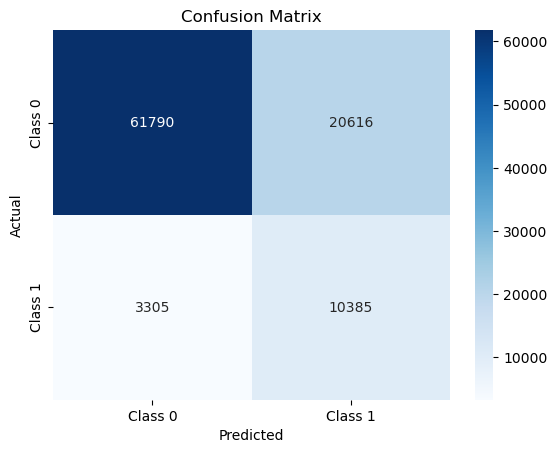

In [60]:
# confusion matrix 

draw_confusion_matrix(y_test, y_pred)

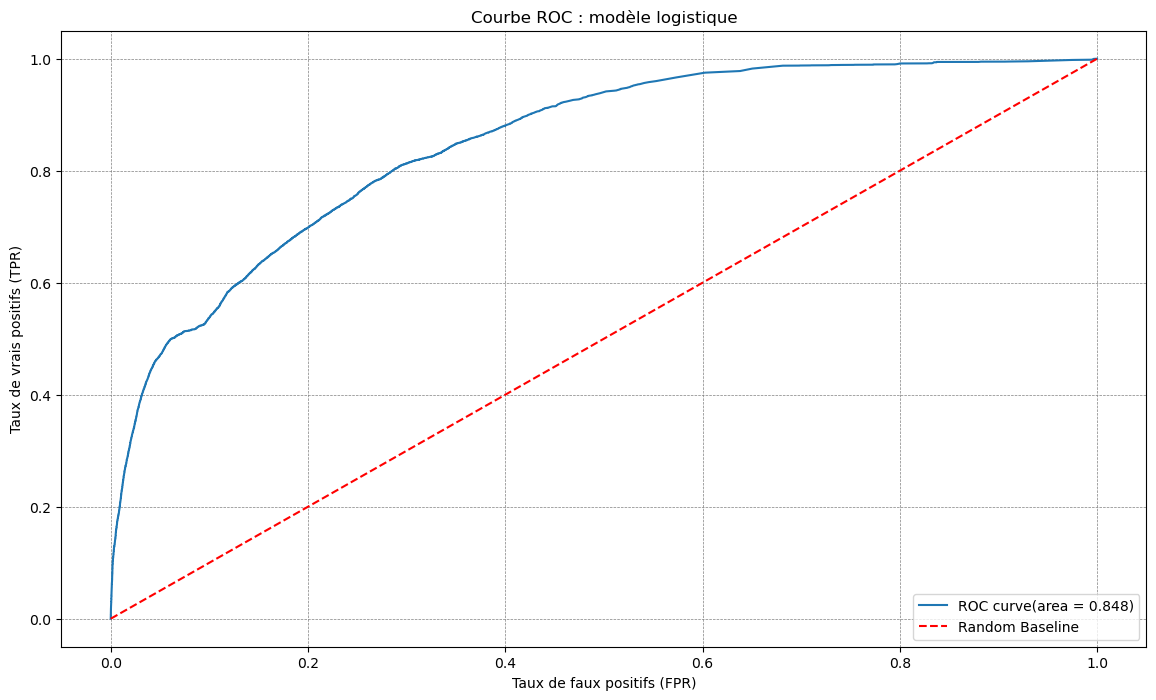

In [61]:
# ROC curve

# Calcul des taux de faux positifs (FPR) et de vrais positifs (TPR)
y_pred_prob = logit_grid.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)

# Calcul de l'aire sous la courbe ROC (AUC)
roc_auc = auc(fpr, tpr)

plt.figure(figsize = (14, 8))
plt.plot(fpr, tpr, label="ROC curve(area = %0.3f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="red",label="Random Baseline", linestyle="--")
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC : modèle logistique')
plt.legend(loc="lower right")
plt.show()

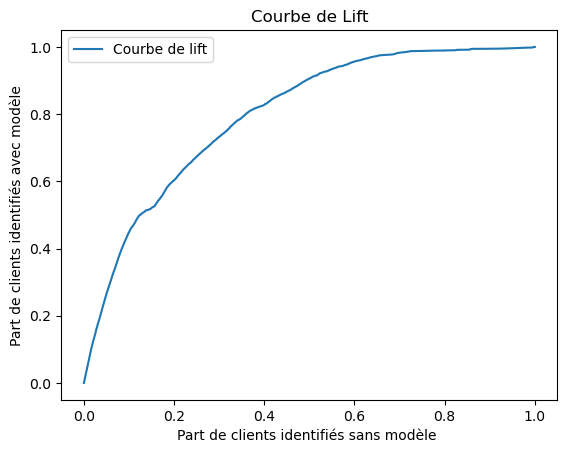

In [62]:
# utilisation d'une métrique plus adaptée aux modèles de marketing : courbe de lift

# Tri des prédictions de probabilités et des vraies valeurs
sorted_indices = np.argsort(y_pred_prob)[::-1]
y_pred_prob_sorted = y_pred_prob[sorted_indices]
y_test_sorted = y_test.iloc[sorted_indices]

# Calcul du gain cumulatif
cumulative_gain = np.cumsum(y_test_sorted) / np.sum(y_test_sorted)

# Tracé de la courbe de lift
plt.plot(np.linspace(0, 1, len(cumulative_gain)), cumulative_gain, label='Courbe de lift')
plt.xlabel('Part de clients identifiés sans modèle ')
plt.ylabel('Part de clients identifiés avec modèle')
plt.title('Courbe de Lift')
plt.legend()
plt.show()

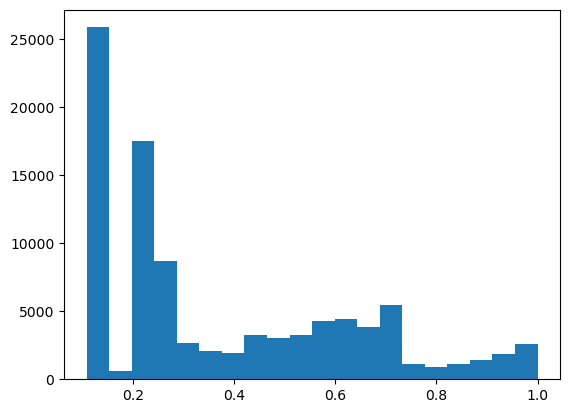

In [63]:
# look at the distribution of the score 

plt.hist(y_pred_prob, bins=20)
plt.show()

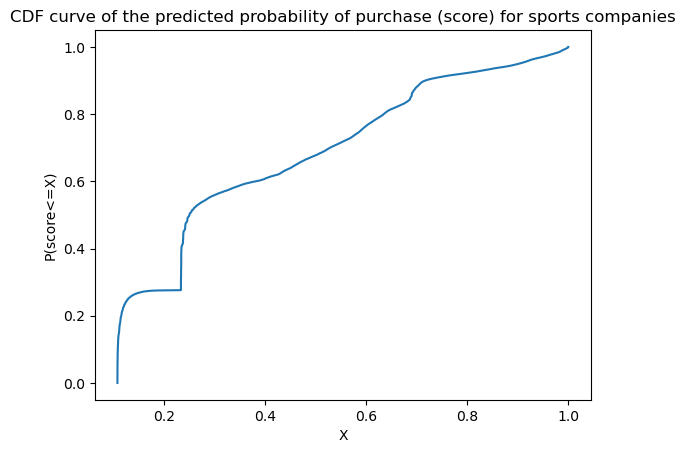

In [64]:
# number of observations
N = len(y_pred_prob)

# sort the data in ascending order 
y_pred_prob_sorted = np.sort(y_pred_prob) 

# get the cdf values of y 
steps = np.arange(N) / N
  
# plotting 
plt.xlabel('X') 
plt.ylabel('P(score<=X)') 
  
plt.title('CDF curve of the predicted probability of purchase (score) for sports companies') 
  
plt.plot(y_pred_prob_sorted, steps) 
plt.show()

### K-means clustering

In [66]:
# K-means clustering 

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=0)

kmeans.fit(y_pred_prob.reshape(-1,1))

KMeans(n_clusters=3, random_state=0)

In [67]:
y_clusters = kmeans.predict(y_pred_prob.reshape(-1,1))
y_clusters

array([1, 0, 0, ..., 0, 1, 0], dtype=int32)

In [75]:
# seuils des clusters et part de clients dans chacun d'eux

print(f"seuil cluster 0 : {y_pred_prob[y_clusters==0].max()} ({round(100 * (y_clusters==0).mean(), 2)}%)")
print(f"seuil cluster 1 : {y_pred_prob[y_clusters==1].max()} ({round(100 * (y_clusters==1).mean(), 2)}%)")
print(f"seuil cluster 2 : {y_pred_prob[y_clusters==2].max()} ({round(100* (y_clusters==2).mean(), 2)}%)")

seuil cluster 0 : 0.38635624748849917 (60.14%)
seuil cluster 1 : 0.7395110401019087 (30.69%)
seuil cluster 2 : 1.0 (9.16%)


In [76]:
# les individus des clusters sont-ils semblables ? def des marketing personae

X_test_clustered = X_test.assign(cluster = y_clusters)
X_test_clustered.head()

nb_tickets  nb_purchases  total_amount  nb_suppliers  vente_internet_max  \
0         4.0           1.0         100.0           1.0                 0.0   
1         1.0           1.0          55.0           1.0                 0.0   
2        17.0           1.0          80.0           1.0                 0.0   
3         4.0           1.0         120.0           1.0                 0.0   
4        34.0           2.0         416.0           1.0                 0.0   

   purchase_date_min  purchase_date_max  nb_tickets_internet  is_email_true  \
0           5.177187           5.177187                  0.0           True   
1         426.265613         426.265613                  0.0           True   
2         436.033437         436.033437                  0.0           True   
3           5.196412           5.196412                  0.0           True   
4         478.693148         115.631470                  0.0           True   

   opt_in  gender_female  gender_male  nb_campaigns  nb_campaigns_opened  \
0   False              1            0           0.0                  0.0   
1    True              0            1           0.0                  0.0   
2    True              1            0           0.0                  0.0   
3   False              1            0           0.0                  0.0   
4   False              1            0           0.0                  0.0   

   cluster  
0        1  
1        0  
2        0  
3        1  
4        2

In [79]:
X_test_clustered.groupby("cluster").median().iloc[[0,1,2], :]

nb_tickets  nb_purchases  total_amount  nb_suppliers  \
cluster                                                         
0               0.0           0.0          0.00           0.0   
1               2.0           1.0         60.00           1.0   
2              13.0           4.0        209.26           1.0   

         vente_internet_max  purchase_date_min  purchase_date_max  \
cluster                                                             
0                       0.0         550.000000         550.000000   
1                       1.0         222.437500         214.639152   
2                       1.0         418.270723          56.167392   

         nb_tickets_internet  is_email_true  opt_in  gender_female  \
cluster                                                              
0                        0.0            1.0     1.0            0.0   
1                        1.0            1.0     0.0            0.0   
2                        3.0            1.0     0.0            0.0   

         gender_male  nb_campaigns  nb_campaigns_opened  
cluster                                                  
0                0.0           7.0                  0.0  
1                1.0           3.0                  0.0  
2                1.0          18.0                  1.0

In [80]:
X_test_clustered.groupby("cluster").mean().iloc[[0,1,2], :]

nb_tickets  nb_purchases  total_amount  nb_suppliers  \
cluster                                                         
0          0.311325      0.114404      6.707697      0.102898   
1          2.926055      1.395389     82.976104      1.000136   
2         44.841472     11.576993   1942.145881      1.493641   

         vente_internet_max  purchase_date_min  purchase_date_max  \
cluster                                                             
0                  0.048741         527.762945         527.621410   
1                  0.681539         228.303268         217.641649   
2                  0.742562         382.346041          87.811798   

         nb_tickets_internet  is_email_true    opt_in  gender_female  \
cluster                                                                
0                   0.137313       1.000000  0.561640       0.239934   
1                   1.736769       0.990202  0.145618       0.260553   
2                  12.613786       0.971724  0.132637       0.199182   

         gender_male  nb_campaigns  nb_campaigns_opened  
cluster                                                  
0           0.450610     12.881201             2.163647  
1           0.536871      9.821800             2.811663  
2           0.621735     20.781399             8.329548

### Quartile clustering

In [82]:
# quartile clustering

X_test["score"] = y_pred_prob
X_test.head()

nb_tickets  nb_purchases  total_amount  nb_suppliers  vente_internet_max  \
0         4.0           1.0         100.0           1.0                 0.0   
1         1.0           1.0          55.0           1.0                 0.0   
2        17.0           1.0          80.0           1.0                 0.0   
3         4.0           1.0         120.0           1.0                 0.0   
4        34.0           2.0         416.0           1.0                 0.0   

   purchase_date_min  purchase_date_max  nb_tickets_internet  is_email_true  \
0           5.177187           5.177187                  0.0           True   
1         426.265613         426.265613                  0.0           True   
2         436.033437         436.033437                  0.0           True   
3           5.196412           5.196412                  0.0           True   
4         478.693148         115.631470                  0.0           True   

   opt_in  gender_female  gender_male  nb_campaigns  nb_campaigns_opened  \
0   False              1            0           0.0                  0.0   
1    True              0            1           0.0                  0.0   
2    True              1            0           0.0                  0.0   
3   False              1            0           0.0                  0.0   
4   False              1            0           0.0                  0.0   

      score  
0  0.695913  
1  0.244205  
2  0.279592  
3  0.696135  
4  0.911844

In [ ]:
df['new_column'] = np.where(df['col2']<9, 'value1',
                   np.where(df['col2']<12, 'value2',
                   np.where(df['col2']<15, 'value3', 'value4')))

In [83]:
X_test["quartile"] = np.where(X_test['score']<0.25, '1',
                   np.where(X_test['score']<0.5, '2',
                   np.where(X_test['score']<0.75, '3', '4')))
X_test.head(10)

nb_tickets  nb_purchases  total_amount  nb_suppliers  vente_internet_max  \
0         4.0           1.0         100.0           1.0                 0.0   
1         1.0           1.0          55.0           1.0                 0.0   
2        17.0           1.0          80.0           1.0                 0.0   
3         4.0           1.0         120.0           1.0                 0.0   
4        34.0           2.0         416.0           1.0                 0.0   
5         2.0           1.0          60.0           1.0                 0.0   
6         5.0           1.0          61.0           1.0                 1.0   
7         4.0           1.0          80.0           1.0                 0.0   
8         1.0           1.0          10.0           1.0                 0.0   
9         3.0           3.0         165.0           1.0                 1.0   

   purchase_date_min  purchase_date_max  nb_tickets_internet  is_email_true  \
0           5.177187           5.177187                  0.0           True   
1         426.265613         426.265613                  0.0           True   
2         436.033437         436.033437                  0.0           True   
3           5.196412           5.196412                  0.0           True   
4         478.693148         115.631470                  0.0           True   
5           5.140069           5.140069                  0.0           True   
6         105.053773         105.053773                  5.0           True   
7          63.206030          63.206030                  0.0           True   
8          44.698090          44.698090                  0.0           True   
9         266.012106         258.012106                  3.0           True   

   opt_in  gender_female  gender_male  nb_campaigns  nb_campaigns_opened  \
0   False              1            0           0.0                  0.0   
1    True              0            1           0.0                  0.0   
2    True              1            0           0.0                  0.0   
3   False              1            0           0.0                  0.0   
4   False              1            0           0.0                  0.0   
5   False              0            1           0.0                  0.0   
6   False              0            0           0.0                  0.0   
7    True              0            1           0.0                  0.0   
8    True              0            0           0.0                  0.0   
9   False              0            0           0.0                  0.0   

      score quartile  
0  0.695913        3  
1  0.244205        1  
2  0.279592        2  
3  0.696135        3  
4  0.911844        4  
5  0.690015        3  
6  0.663391        3  
7  0.441604        2  
8  0.441933        2  
9  0.581348        3

In [84]:
# size of each segment

X_test.groupby("quartile").size()

quartile
1    47871
2    17224
3    22481
4     8520
dtype: int64

In [87]:
# check consistency of quartiles (we have an upward bias, which is explained by the fact that we want a decent recall)

X_test["has_purchased"] = y_test
X_test.groupby("quartile").mean()

nb_tickets  nb_purchases  total_amount  nb_suppliers  \
quartile                                                         
1           0.017380      0.008586      0.475141      0.008439   
2           2.085810      0.880283     49.701732      0.742336   
3           3.118100      1.478893     88.811284      1.003292   
4          46.046362     11.842254   2002.607230      1.508685   

          vente_internet_max  purchase_date_min  purchase_date_max  \
quartile                                                             
1                   0.001358         549.044552         549.044465   
2                   0.420866         381.428495         379.188470   
3                   0.703349         198.284116         184.197970   
4                   0.743192         386.401662          85.808238   

          nb_tickets_internet  is_email_true    opt_in  gender_female  \
quartile                                                                
1                    0.003071       1.000000  0.562157       0.232416   
2                    1.044473       0.998374  0.507083       0.264515   
3                    1.879098       0.988123  0.051777       0.264001   
4                   12.894131       0.971479  0.130751       0.198239   

          gender_male  nb_campaigns  nb_campaigns_opened     score  \
quartile                                                             
1            0.416536     11.860521             1.648430  0.169233   
2            0.596435     14.593184             3.725732  0.360811   
3            0.526534      9.773898             2.978115  0.626785   
4            0.622418     20.928286             8.367723  0.902055   

          has_purchased  
quartile                 
1              0.026780  
2              0.117452  
3              0.209332  
4              0.666549

Méthode \
On étudie le rythme d'achat des clients et on suppose qu'il sera le même dans le futur

In [106]:
# purchasing pace by segment

X_test["consumption_lifetime"] = X_test["purchase_date_min"] - X_test["purchase_date_max"]

In [113]:
X_test["consumption_lifetime"].describe()

count    96096.000000
mean        30.347912
std         95.435372
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        547.122986
Name: consumption_lifetime, dtype: float64

In [149]:
X_test["avg_purchase_delay"] = (X_test["consumption_lifetime"]/X_test["nb_purchases"]).replace([np.inf, -np.inf], 0)

In [150]:
X_test[X_test["avg_purchase_delay"]>0]

nb_tickets  nb_purchases  total_amount  nb_suppliers  \
4            34.0           2.0        416.00           1.0   
9             3.0           3.0        165.00           1.0   
16           23.0          14.0        600.00           2.0   
21           21.0           3.0       1075.00           1.0   
22            4.0           2.0        140.00           1.0   
...           ...           ...           ...           ...   
95943         2.0           2.0          0.00           1.0   
95989         2.0           2.0         77.31           2.0   
95996         3.0           3.0        273.76           2.0   
96043         2.0           2.0        136.42           1.0   
96079         2.0           2.0          0.00           1.0   

       vente_internet_max  purchase_date_min  purchase_date_max  \
4                     0.0         478.693148         115.631470   
9                     1.0         266.012106         258.012106   
16                    1.0         453.423519          15.225949   
21                    0.0         431.817072         230.432350   
22                    0.0         277.254745          12.438877   
...                   ...                ...                ...   
95943                 0.0         545.673137         362.284745   
95989                 1.0         271.676632           6.289577   
95996                 1.0         202.691389           7.142274   
96043                 1.0         363.119815         173.225752   
96079                 0.0         355.131933         355.128542   

       nb_tickets_internet  is_email_true  opt_in  gender_female  gender_male  \
4                      0.0           True   False              1            0   
9                      3.0           True   False              0            0   
16                     1.0           True   False              0            1   
21                     0.0           True    True              0            1   
22                     0.0           True    True              0            1   
...                    ...            ...     ...            ...          ...   
95943                  0.0           True   False              1            0   
95989                  1.0           True   False              1            0   
95996                  2.0           True   False              0            1   
96043                  2.0           True   False              0            1   
96079                  0.0           True   False              1            0   

       nb_campaigns  nb_campaigns_opened     score quartile  has_purchased  \
4               0.0                  0.0  0.911844        4            1.0   
9               0.0                  0.0  0.581348        3            0.0   
16              0.0                  0.0  0.970052        4            1.0   
21              0.0                  0.0  0.599176        3            0.0   
22              0.0                  0.0  0.707939        3            1.0   
...             ...                  ...       ...      ...            ...   
95943          46.0                  9.0  0.707163        3            0.0   
95989          21.0                  6.0  0.937049        4            0.0   
95996          25.0                  3.0  0.916446        4            1.0   
96043          35.0                 29.0  0.866743        4            1.0   
96079          50.0                 42.0  0.720674        3            0.0   

       consumption_lifetime  avg_purchase_delay  
4                363.061678          181.530839  
9                  8.000000            2.666667  
16               438.197569           31.299826  
21               201.384722           67.128241  
22               264.815868          132.407934  
...                     ...                 ...  
95943            183.388391           91.694196  
95989            265.387055          132.693527  
95996            195.549115           65.183038  
96043            189.894062        

In [157]:
X_test[X_test["avg_purchase_delay"]>0].groupby("quartile")[["nb_purchases", "consumption_lifetime", "avg_purchase_delay"]].mean()

nb_purchases  consumption_lifetime  avg_purchase_delay
quartile                                                        
1             2.000000              0.597093            0.298547
2             2.592668             26.192927           11.435486
3             3.203764             64.785322           25.490483
4            12.041836            306.126700           68.659817

In [156]:
X_test[X_test["avg_purchase_delay"]>0].isna().sum()

nb_tickets              0
nb_purchases            0
total_amount            0
nb_suppliers            0
vente_internet_max      0
purchase_date_min       0
purchase_date_max       0
nb_tickets_internet     0
is_email_true           0
opt_in                  0
gender_female           0
gender_male             0
nb_campaigns            0
nb_campaigns_opened     0
score                   0
quartile                0
has_purchased           0
consumption_lifetime    0
avg_purchase_delay      0
dtype: int64

Etude du biais de surestimation

In [250]:
((10 * X_test["score"]).astype(int)).describe()

count    96096.000000
mean         3.362075
std          2.425080
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max         10.000000
Name: score, dtype: float64

In [255]:
# le biais de surestimation décroit avec le score 
X_test.groupby("quartile")["score"].mean() / X_test.groupby("quartile")["has_purchased"].mean()

quartile
1    6.319295
2    3.071979
3    2.994212
4    1.353321
dtype: float64

In [275]:
# on prend un decoupage plus fin : deciles

X_test["decile"] = (10 * X_test["score"]).astype(int)
X_test["decile"] = X_test["decile"].apply(lambda x : x-1 if x==10 else x)
X_test

nb_tickets  nb_purchases  total_amount  nb_suppliers  \
0             4.0           1.0        100.00           1.0   
1             1.0           1.0         55.00           1.0   
2            17.0           1.0         80.00           1.0   
3             4.0           1.0        120.00           1.0   
4            34.0           2.0        416.00           1.0   
...           ...           ...           ...           ...   
96091         1.0           1.0         67.31           1.0   
96092         1.0           1.0         61.41           1.0   
96093         0.0           0.0          0.00           0.0   
96094         1.0           1.0         79.43           1.0   
96095         0.0           0.0          0.00           0.0   

       vente_internet_max  purchase_date_min  purchase_date_max  \
0                     0.0           5.177187           5.177187   
1                     0.0         426.265613         426.265613   
2                     0.0         436.033437         436.033437   
3                     0.0           5.196412           5.196412   
4                     0.0         478.693148         115.631470   
...                   ...                ...                ...   
96091                 1.0         278.442257         278.442257   
96092                 1.0         189.207373         189.207373   
96093                 0.0         550.000000         550.000000   
96094                 1.0         279.312905         279.312905   
96095                 0.0         550.000000         550.000000   

       nb_tickets_internet  is_email_true  opt_in  ...  nb_campaigns_opened  \
0                      0.0           True   False  ...                  0.0   
1                      0.0           True    True  ...                  0.0   
2                      0.0           True    True  ...                  0.0   
3                      0.0           True   False  ...                  0.0   
4                      0.0           True   False  ...                  0.0   
...                    ...            ...     ...  ...                  ...   
96091                  1.0           True   False  ...                  5.0   
96092                  1.0           True   False  ...                  9.0   
96093                  0.0           True    True  ...                  3.0   
96094                  1.0           True   False  ...                  4.0   
96095                  0.0           True   False  ...                  4.0   

          score  quartile  has_purchased  consumption_lifetime  \
0      0.695913         3            0.0              0.000000   
1      0.244205         1            1.0              0.000000   
2      0.279592         2            0.0              0.000000   
3      0.696135         3            0.0              0.000000   
4      0.911844         4            1.0            363.061678   
...         ...       ...            ...                   ...   
96091  0.584680         3            1.0              0.000000   
96092  0.654520         3            0.0              0.000000   
96093  0.116503         1            0.0              0.000000   
96094  0.579827         3            0.0              0.000000   
96095  0.254002         2            0.0              0.000000   

      avg_purchase_delay  avg_purchase_delay_all  avg_tickets_delay  \
0               0.000000                5.177187           0.000000   
1               0.000000              426.265613           0.000000   
2               0.000000              436.033437           0.000000   
3               0.000000                5.196412           0.000000   
4             181.530839              239.346574          10.678285   
...                  ...                     ...                ...   
96091           0.000000              278.442257           0.000000   
96092           0.000000              189.207373           0.000000   
96093                NaN                0.000000                

In [276]:
X_test.groupby("decile")["score"].mean() / X_test.groupby("decile")["has_purchased"].mean()

decile
1    17.863019
2     3.826401
3     3.179880
4     3.392496
5     3.260982
6     3.294104
7     1.850487
8     1.489675
9     1.268598
dtype: float64

In [277]:
# pour les scores entre 0.1 et 0.2, la proba d'achat est de 0.6% elle est largement surestimée ici
X_test[X_test["decile"]==1]["has_purchased"].mean()

0.006422122322541649

In [284]:
# create a variable to approximate the overestimation by decile

# dictionnary mapping decile of the score and average overestimation
mapping_score_overshoot = dict(X_test.groupby("decile")["score"].mean() / X_test.groupby("decile")["has_purchased"].mean())
X_test["overshoot_coeff"] = X_test["decile"].map(mapping_score_overshoot)
X_test

nb_tickets  nb_purchases  total_amount  nb_suppliers  \
0             4.0           1.0        100.00           1.0   
1             1.0           1.0         55.00           1.0   
2            17.0           1.0         80.00           1.0   
3             4.0           1.0        120.00           1.0   
4            34.0           2.0        416.00           1.0   
...           ...           ...           ...           ...   
96091         1.0           1.0         67.31           1.0   
96092         1.0           1.0         61.41           1.0   
96093         0.0           0.0          0.00           0.0   
96094         1.0           1.0         79.43           1.0   
96095         0.0           0.0          0.00           0.0   

       vente_internet_max  purchase_date_min  purchase_date_max  \
0                     0.0           5.177187           5.177187   
1                     0.0         426.265613         426.265613   
2                     0.0         436.033437         436.033437   
3                     0.0           5.196412           5.196412   
4                     0.0         478.693148         115.631470   
...                   ...                ...                ...   
96091                 1.0         278.442257         278.442257   
96092                 1.0         189.207373         189.207373   
96093                 0.0         550.000000         550.000000   
96094                 1.0         279.312905         279.312905   
96095                 0.0         550.000000         550.000000   

       nb_tickets_internet  is_email_true  opt_in  ...     score  quartile  \
0                      0.0           True   False  ...  0.695913         3   
1                      0.0           True    True  ...  0.244205         1   
2                      0.0           True    True  ...  0.279592         2   
3                      0.0           True   False  ...  0.696135         3   
4                      0.0           True   False  ...  0.911844         4   
...                    ...            ...     ...  ...       ...       ...   
96091                  1.0           True   False  ...  0.584680         3   
96092                  1.0           True   False  ...  0.654520         3   
96093                  0.0           True    True  ...  0.116503         1   
96094                  1.0           True   False  ...  0.579827         3   
96095                  0.0           True   False  ...  0.254002         2   

       has_purchased  consumption_lifetime  avg_purchase_delay  \
0                0.0              0.000000            0.000000   
1                1.0              0.000000            0.000000   
2                0.0              0.000000            0.000000   
3                0.0              0.000000            0.000000   
4                1.0            363.061678          181.530839   
...              ...                   ...                 ...   
96091            1.0              0.000000            0.000000   
96092            0.0              0.000000            0.000000   
96093            0.0              0.000000                 NaN   
96094            0.0              0.000000            0.000000   
96095            0.0              0.000000                 NaN   

      avg_purchase_delay_all  avg_tickets_delay  avg_tickets_delay_all  \
0                   5.177187           0.000000               1.294297   
1                 426.265613           0.000000             426.265613   
2                 436.033437           0.000000              25.649026   
3                   5.196412           0.000000               1.299103   
4                 239.346574          10.678285              14.079210   
...                      ...                ...                    ...   
96091             278.442257           0.000000             278.442257   
96092             189.207373           0.000000             189.207373   
96093               0.000000                NaN  

In [285]:
X_test["ajusted_score"] = X_test["score"]/X_test["overshoot_coeff"]
X_test

nb_tickets  nb_purchases  total_amount  nb_suppliers  \
0             4.0           1.0        100.00           1.0   
1             1.0           1.0         55.00           1.0   
2            17.0           1.0         80.00           1.0   
3             4.0           1.0        120.00           1.0   
4            34.0           2.0        416.00           1.0   
...           ...           ...           ...           ...   
96091         1.0           1.0         67.31           1.0   
96092         1.0           1.0         61.41           1.0   
96093         0.0           0.0          0.00           0.0   
96094         1.0           1.0         79.43           1.0   
96095         0.0           0.0          0.00           0.0   

       vente_internet_max  purchase_date_min  purchase_date_max  \
0                     0.0           5.177187           5.177187   
1                     0.0         426.265613         426.265613   
2                     0.0         436.033437         436.033437   
3                     0.0           5.196412           5.196412   
4                     0.0         478.693148         115.631470   
...                   ...                ...                ...   
96091                 1.0         278.442257         278.442257   
96092                 1.0         189.207373         189.207373   
96093                 0.0         550.000000         550.000000   
96094                 1.0         279.312905         279.312905   
96095                 0.0         550.000000         550.000000   

       nb_tickets_internet  is_email_true  opt_in  ...  quartile  \
0                      0.0           True   False  ...         3   
1                      0.0           True    True  ...         1   
2                      0.0           True    True  ...         2   
3                      0.0           True   False  ...         3   
4                      0.0           True   False  ...         4   
...                    ...            ...     ...  ...       ...   
96091                  1.0           True   False  ...         3   
96092                  1.0           True   False  ...         3   
96093                  0.0           True    True  ...         1   
96094                  1.0           True   False  ...         3   
96095                  0.0           True   False  ...         2   

       has_purchased  consumption_lifetime  avg_purchase_delay  \
0                0.0              0.000000            0.000000   
1                1.0              0.000000            0.000000   
2                0.0              0.000000            0.000000   
3                0.0              0.000000            0.000000   
4                1.0            363.061678          181.530839   
...              ...                   ...                 ...   
96091            1.0              0.000000            0.000000   
96092            0.0              0.000000            0.000000   
96093            0.0              0.000000                 NaN   
96094            0.0              0.000000            0.000000   
96095            0.0              0.000000                 NaN   

       avg_purchase_delay_all avg_tickets_delay  avg_tickets_delay_all  \
0                    5.177187          0.000000               1.294297   
1                  426.265613          0.000000             426.265613   
2                  436.033437          0.000000              25.649026   
3                    5.196412          0.000000               1.299103   
4                  239.346574         10.678285              14.079210   
...                       ...               ...                    ...   
96091              278.442257          0.000000             278.442257   
96092              189.207373          0.000000             189.207373   
96093                0.000000               NaN               0.000000   
96094              279.312905          0.000000             279.312905   
96095                

In [788]:
# difference between proba estimated and y has purchased
# the calibration allows to half the MSE

MSE_score = ((X_test["score"]-X_test["has_purchased"])**2).mean()
MSE_ajusted_score = ((X_test["score_adjusted"]-X_test["has_purchased"])**2).mean()
print(f"MSE for score : {MSE_score}")
print(f"MSE for adjusted score : {MSE_ajusted_score}")

MSE for score : 0.15637498623391197
MSE for adjusted score : 0.08877832832116543


In [787]:
# mean absolute error - divided by 2 with out method

MAE_score = abs(X_test["score"]-X_test["has_purchased"]).mean()
MAE_ajusted_score = abs(X_test["score_adjusted"]-X_test["has_purchased"]).mean()
print(f"MAE for score : {MAE_score}")
print(f"MAE for adjusted score : {MAE_ajusted_score}")

MAE for score : 0.32574831037767815
MAE for adjusted score : 0.17556035724742763


New method to adjust - best way to fit the logit model

In [317]:
# au global, la prbabilité d'achat est largement surestimée, il ft corriger
print("somme des scores :", X_test["score"].sum())
print("nombre d'achats : ", y_test.sum())

somme des scores : 36092.22480054577
nombre d'achats :  y_has_purchased    13690.0
dtype: float64


In [311]:
# 1. calcul du biais



36092.22480054577

In [375]:
# premier problème : certains scores valent 1, ce qui empeche de calculer un odd ratio 
# on remplace les scores de 1 par 0.999

X_test["score"] = X_test["score"].apply(lambda x : 0.9999999999999996 if x==1 else x)
X_test

nb_tickets  nb_purchases  total_amount  nb_suppliers  \
0             4.0           1.0        100.00           1.0   
1             1.0           1.0         55.00           1.0   
2            17.0           1.0         80.00           1.0   
3             4.0           1.0        120.00           1.0   
4            34.0           2.0        416.00           1.0   
...           ...           ...           ...           ...   
96091         1.0           1.0         67.31           1.0   
96092         1.0           1.0         61.41           1.0   
96093         0.0           0.0          0.00           0.0   
96094         1.0           1.0         79.43           1.0   
96095         0.0           0.0          0.00           0.0   

       vente_internet_max  purchase_date_min  purchase_date_max  \
0                     0.0           5.177187           5.177187   
1                     0.0         426.265613         426.265613   
2                     0.0         436.033437         436.033437   
3                     0.0           5.196412           5.196412   
4                     0.0         478.693148         115.631470   
...                   ...                ...                ...   
96091                 1.0         278.442257         278.442257   
96092                 1.0         189.207373         189.207373   
96093                 0.0         550.000000         550.000000   
96094                 1.0         279.312905         279.312905   
96095                 0.0         550.000000         550.000000   

       nb_tickets_internet  is_email_true  opt_in  ...  consumption_lifetime  \
0                      0.0           True   False  ...              0.000000   
1                      0.0           True    True  ...              0.000000   
2                      0.0           True    True  ...              0.000000   
3                      0.0           True   False  ...              0.000000   
4                      0.0           True   False  ...            363.061678   
...                    ...            ...     ...  ...                   ...   
96091                  1.0           True   False  ...              0.000000   
96092                  1.0           True   False  ...              0.000000   
96093                  0.0           True    True  ...              0.000000   
96094                  1.0           True   False  ...              0.000000   
96095                  0.0           True   False  ...              0.000000   

       avg_purchase_delay  avg_purchase_delay_all  avg_tickets_delay  \
0                0.000000                5.177187           0.000000   
1                0.000000              426.265613           0.000000   
2                0.000000              436.033437           0.000000   
3                0.000000                5.196412           0.000000   
4              181.530839              239.346574          10.678285   
...                   ...                     ...                ...   
96091            0.000000              278.442257           0.000000   
96092            0.000000              189.207373           0.000000   
96093                 NaN                0.000000                NaN   
96094            0.000000              279.312905           0.000000   
96095                 NaN                0.000000                NaN   

       avg_tickets_delay_all decile  overshoot_coeff  ajusted_score  \
0                   1.294297      6         3.294104       0.211260   
1                 426.265613      2         3.826401       0.063821   
2                  25.649026      2         3.826401       0.073069   
3                   1.299103      6         3.294104       0.211328   
4                  14.079210      9         1.268598       0.718781   
...                      ...    ...              ...            ...   
96091             278.442257      5         3.260982       0.179296   
96092             189.207373      6         3.29410

In [377]:
X_test["odd_ratio"] = X_test["score"]/(1-X_test["score"])
X_test

nb_tickets  nb_purchases  total_amount  nb_suppliers  \
0             4.0           1.0        100.00           1.0   
1             1.0           1.0         55.00           1.0   
2            17.0           1.0         80.00           1.0   
3             4.0           1.0        120.00           1.0   
4            34.0           2.0        416.00           1.0   
...           ...           ...           ...           ...   
96091         1.0           1.0         67.31           1.0   
96092         1.0           1.0         61.41           1.0   
96093         0.0           0.0          0.00           0.0   
96094         1.0           1.0         79.43           1.0   
96095         0.0           0.0          0.00           0.0   

       vente_internet_max  purchase_date_min  purchase_date_max  \
0                     0.0           5.177187           5.177187   
1                     0.0         426.265613         426.265613   
2                     0.0         436.033437         436.033437   
3                     0.0           5.196412           5.196412   
4                     0.0         478.693148         115.631470   
...                   ...                ...                ...   
96091                 1.0         278.442257         278.442257   
96092                 1.0         189.207373         189.207373   
96093                 0.0         550.000000         550.000000   
96094                 1.0         279.312905         279.312905   
96095                 0.0         550.000000         550.000000   

       nb_tickets_internet  is_email_true  opt_in  ...  consumption_lifetime  \
0                      0.0           True   False  ...              0.000000   
1                      0.0           True    True  ...              0.000000   
2                      0.0           True    True  ...              0.000000   
3                      0.0           True   False  ...              0.000000   
4                      0.0           True   False  ...            363.061678   
...                    ...            ...     ...  ...                   ...   
96091                  1.0           True   False  ...              0.000000   
96092                  1.0           True   False  ...              0.000000   
96093                  0.0           True    True  ...              0.000000   
96094                  1.0           True   False  ...              0.000000   
96095                  0.0           True   False  ...              0.000000   

       avg_purchase_delay  avg_purchase_delay_all  avg_tickets_delay  \
0                0.000000                5.177187           0.000000   
1                0.000000              426.265613           0.000000   
2                0.000000              436.033437           0.000000   
3                0.000000                5.196412           0.000000   
4              181.530839              239.346574          10.678285   
...                   ...                     ...                ...   
96091            0.000000              278.442257           0.000000   
96092            0.000000              189.207373           0.000000   
96093                 NaN                0.000000                NaN   
96094            0.000000              279.312905           0.000000   
96095                 NaN                0.000000                NaN   

       avg_tickets_delay_all decile  overshoot_coeff  ajusted_score  \
0                   1.294297      6         3.294104       0.211260   
1                 426.265613      2         3.826401       0.063821   
2                  25.649026      2         3.826401       0.073069   
3                   1.299103      6         3.294104       0.211328   
4                  14.079210      9         1.268598       0.718781   
...                      ...    ...              ...            ...   
96091             278.442257      5         3.260982       0.179296   
96092             189.207373      6         3.29410

In [378]:
X_test["odd_ratio"].describe()

count    9.609600e+04
mean     2.117164e+11
std      2.179173e+13
min      1.207494e-01
25%      1.476621e-01
50%      3.337214e-01
75%      1.430245e+00
max      2.251800e+15
Name: odd_ratio, dtype: float64

In [381]:
def adjusted_score(odd_ratio, bias) :
    adjusted_score = odd_ratio/(bias+odd_ratio)
    return adjusted_score

In [424]:
def obj_function(bias) :
    obj = sum([adjusted_score(element, bias) for element in X_test["odd_ratio"]]) # - y_test.sum()["y_has_purchased"]
    return obj

In [380]:
y_test.sum()["y_has_purchased"]

13690.0

In [396]:
# le biais optimal se trouve aux alentours de 6
sum([adjusted_score(element, 6) for element in X_test["odd_ratio"]])

13749.42306555955

In [411]:
sum([adjusted_score(element, 1) for element in X_test["odd_ratio"]])

36092.2248005385

In [412]:
y_test.sum()["y_has_purchased"]

13690.0

In [425]:
obj_function(1)

36092.2248005385

In [423]:
# on devrait trouver un résultat autour de 6.04
sum([adjusted_score(element, 6.04) for element in X_test["odd_ratio"]]) - y_test.sum()["y_has_purchased"]

3.9020966429798136

In [426]:
# minimization

from scipy.optimize import minimize


y_sum = y_test.sum()["y_has_purchased"]
initial_guess = 6
estimated_biais = minimize(lambda bias : (obj_function(bias)-y_sum)**2 ,
initial_guess , method = "BFGS")

In [430]:
print(f"bias estimated : {estimated_biais.x[0]}")

bias estimated : 6.042826489667565


In [435]:
# on corrige les scores trouvés en fonction

X_test["score_adjusted"] = adjusted_score(X_test["odd_ratio"], bias=estimated_biais.x[0])
X_test

nb_tickets  nb_purchases  total_amount  nb_suppliers  \
0             4.0           1.0        100.00           1.0   
1             1.0           1.0         55.00           1.0   
2            17.0           1.0         80.00           1.0   
3             4.0           1.0        120.00           1.0   
4            34.0           2.0        416.00           1.0   
...           ...           ...           ...           ...   
96091         1.0           1.0         67.31           1.0   
96092         1.0           1.0         61.41           1.0   
96093         0.0           0.0          0.00           0.0   
96094         1.0           1.0         79.43           1.0   
96095         0.0           0.0          0.00           0.0   

       vente_internet_max  purchase_date_min  purchase_date_max  \
0                     0.0           5.177187           5.177187   
1                     0.0         426.265613         426.265613   
2                     0.0         436.033437         436.033437   
3                     0.0           5.196412           5.196412   
4                     0.0         478.693148         115.631470   
...                   ...                ...                ...   
96091                 1.0         278.442257         278.442257   
96092                 1.0         189.207373         189.207373   
96093                 0.0         550.000000         550.000000   
96094                 1.0         279.312905         279.312905   
96095                 0.0         550.000000         550.000000   

       nb_tickets_internet  is_email_true  opt_in  ...  avg_purchase_delay  \
0                      0.0           True   False  ...            0.000000   
1                      0.0           True    True  ...            0.000000   
2                      0.0           True    True  ...            0.000000   
3                      0.0           True   False  ...            0.000000   
4                      0.0           True   False  ...          181.530839   
...                    ...            ...     ...  ...                 ...   
96091                  1.0           True   False  ...            0.000000   
96092                  1.0           True   False  ...            0.000000   
96093                  0.0           True    True  ...                 NaN   
96094                  1.0           True   False  ...            0.000000   
96095                  0.0           True   False  ...                 NaN   

       avg_purchase_delay_all  avg_tickets_delay  avg_tickets_delay_all  \
0                    5.177187           0.000000               1.294297   
1                  426.265613           0.000000             426.265613   
2                  436.033437           0.000000              25.649026   
3                    5.196412           0.000000               1.299103   
4                  239.346574          10.678285              14.079210   
...                       ...                ...                    ...   
96091              278.442257           0.000000             278.442257   
96092              189.207373           0.000000             189.207373   
96093                0.000000                NaN               0.000000   
96094              279.312905           0.000000             279.312905   
96095                0.000000                NaN               0.000000   

       decile overshoot_coeff  ajusted_score  odd_ratio  \
0           6        3.294104       0.211260   2.288530   
1           2        3.826401       0.063821   0.323109   
2           2        3.826401       0.073069   0.388102   
3           6        3.294104       0.211328   2.290940   
4           9        1.268598       0.718781  10.343538   
...       ...             ...            ...        ...   
96091       5        3.260982       0.179296   1.407779   
96092       6        3.294104       0.198694   1.894523   
96093       1       17.863019       0.006522   0.131865   
96094       5    

In [436]:
X_test

nb_tickets  nb_purchases  total_amount  nb_suppliers  \
0             4.0           1.0        100.00           1.0   
1             1.0           1.0         55.00           1.0   
2            17.0           1.0         80.00           1.0   
3             4.0           1.0        120.00           1.0   
4            34.0           2.0        416.00           1.0   
...           ...           ...           ...           ...   
96091         1.0           1.0         67.31           1.0   
96092         1.0           1.0         61.41           1.0   
96093         0.0           0.0          0.00           0.0   
96094         1.0           1.0         79.43           1.0   
96095         0.0           0.0          0.00           0.0   

       vente_internet_max  purchase_date_min  purchase_date_max  \
0                     0.0           5.177187           5.177187   
1                     0.0         426.265613         426.265613   
2                     0.0         436.033437         436.033437   
3                     0.0           5.196412           5.196412   
4                     0.0         478.693148         115.631470   
...                   ...                ...                ...   
96091                 1.0         278.442257         278.442257   
96092                 1.0         189.207373         189.207373   
96093                 0.0         550.000000         550.000000   
96094                 1.0         279.312905         279.312905   
96095                 0.0         550.000000         550.000000   

       nb_tickets_internet  is_email_true  opt_in  ...  avg_purchase_delay  \
0                      0.0           True   False  ...            0.000000   
1                      0.0           True    True  ...            0.000000   
2                      0.0           True    True  ...            0.000000   
3                      0.0           True   False  ...            0.000000   
4                      0.0           True   False  ...          181.530839   
...                    ...            ...     ...  ...                 ...   
96091                  1.0           True   False  ...            0.000000   
96092                  1.0           True   False  ...            0.000000   
96093                  0.0           True    True  ...                 NaN   
96094                  1.0           True   False  ...            0.000000   
96095                  0.0           True   False  ...                 NaN   

       avg_purchase_delay_all  avg_tickets_delay  avg_tickets_delay_all  \
0                    5.177187           0.000000               1.294297   
1                  426.265613           0.000000             426.265613   
2                  436.033437           0.000000              25.649026   
3                    5.196412           0.000000               1.299103   
4                  239.346574          10.678285              14.079210   
...                       ...                ...                    ...   
96091              278.442257           0.000000             278.442257   
96092              189.207373           0.000000             189.207373   
96093                0.000000                NaN               0.000000   
96094              279.312905           0.000000             279.312905   
96095                0.000000                NaN               0.000000   

       decile overshoot_coeff  ajusted_score  odd_ratio  \
0           6        3.294104       0.211260   2.288530   
1           2        3.826401       0.063821   0.323109   
2           2        3.826401       0.073069   0.388102   
3           6        3.294104       0.211328   2.290940   
4           9        1.268598       0.718781  10.343538   
...       ...             ...            ...        ...   
96091       5        3.260982       0.179296   1.407779   
96092       6        3.294104       0.198694   1.894523   
96093       1       17.863019       0.006522   0.131865   
96094       5    

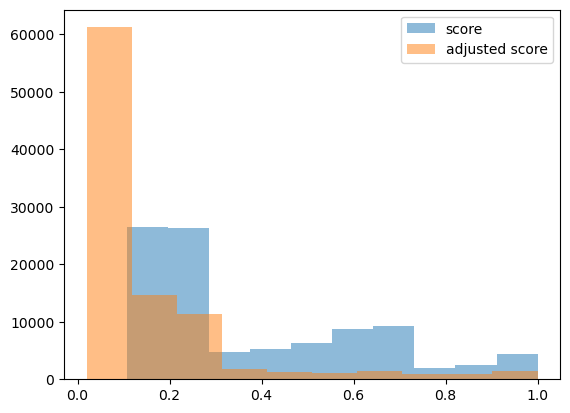

In [549]:
# histogramme des probas et des probas ajustées

plt.hist(X_test["score"], label = "score", alpha=0.5)
plt.hist(X_test["score_adjusted"], label="adjusted score", alpha=0.5)
plt.legend()
plt.show()

In [557]:
# on passe de 32% de scores supérieurs à 1/2 à 6%

print((X_test["score"]>0.5).mean())
print((X_test["score_adjusted"]>0.5).mean())
print(y_test.mean()["y_has_purchased"])

0.32260447885447885
0.06268731268731269
0.14246170496170496


In [437]:
# on vérifie que cette correction a permis d'avoir des résultats cohérents

print("nombre de clients ayant acheté :",y_sum)
print("somme des scores ajustés :", X_test["score_adjusted"].sum())

nombre de clients ayant acheté : 13690.0
somme des scores ajustés : 13690.000010280266


In [440]:
# cet ajustement permet de plus de réduire drastiquement le MSE 

MSE_score = ((X_test["score"]-X_test["has_purchased"])**2).mean()
MSE_ajusted_score = ((X_test["score_adjusted"]-X_test["has_purchased"])**2).mean()
print(f"MSE for score : {MSE_score}")
print(f"MSE for ajusted score : {MSE_ajusted_score}")

MSE for score : 0.15637498623391197
MSE for ajusted score : 0.08877832832116543


In [518]:
# on est bcp plus proche des probas d'achat moyennes
X_test.groupby("quartile")[["score","score_adjusted", "has_purchased"]].mean()

score  score_adjusted  has_purchased
quartile                                         
1         0.169233        0.033442       0.026780
2         0.360811        0.088246       0.117452
3         0.626785        0.222962       0.209332
4         0.902055        0.652198       0.666549

Etape suivante : on peut donc calculer le potentiel de CA de chaque segment

In [473]:
# on calcule d'abord pour chaque client le nombre de tickets achetés / montant total si achat
# comme la période d'étude est d'un an et demi, sur l'année à venir on espère vendre 1.5 fois le nbre de tickets vendu

# ensuite, on multiplie par la proba d'achat pour avoir le nombre de tickets potentiellement acheté
# et le montant total associé


X_test["nb_tickets_projected"] = X_test["nb_tickets"] / 1.5
X_test["total_amount_projected"] = X_test["total_amount"] / 1.5

X_test["nb_tickets_expected"] = X_test["score_adjusted"] * X_test["nb_tickets_projected"]
X_test["total_amount_expected"] = X_test["score_adjusted"] * X_test["total_amount_projected"]

X_test

nb_tickets  nb_purchases  total_amount  nb_suppliers  \
0             4.0           1.0        100.00           1.0   
1             1.0           1.0         55.00           1.0   
2            17.0           1.0         80.00           1.0   
3             4.0           1.0        120.00           1.0   
4            34.0           2.0        416.00           1.0   
...           ...           ...           ...           ...   
96091         1.0           1.0         67.31           1.0   
96092         1.0           1.0         61.41           1.0   
96093         0.0           0.0          0.00           0.0   
96094         1.0           1.0         79.43           1.0   
96095         0.0           0.0          0.00           0.0   

       vente_internet_max  purchase_date_min  purchase_date_max  \
0                     0.0           5.177187           5.177187   
1                     0.0         426.265613         426.265613   
2                     0.0         436.033437         436.033437   
3                     0.0           5.196412           5.196412   
4                     0.0         478.693148         115.631470   
...                   ...                ...                ...   
96091                 1.0         278.442257         278.442257   
96092                 1.0         189.207373         189.207373   
96093                 0.0         550.000000         550.000000   
96094                 1.0         279.312905         279.312905   
96095                 0.0         550.000000         550.000000   

       nb_tickets_internet  is_email_true  opt_in  ...  decile  \
0                      0.0           True   False  ...       6   
1                      0.0           True    True  ...       2   
2                      0.0           True    True  ...       2   
3                      0.0           True   False  ...       6   
4                      0.0           True   False  ...       9   
...                    ...            ...     ...  ...     ...   
96091                  1.0           True   False  ...       5   
96092                  1.0           True   False  ...       6   
96093                  0.0           True    True  ...       1   
96094                  1.0           True   False  ...       5   
96095                  0.0           True   False  ...       2   

       overshoot_coeff  ajusted_score  odd_ratio  test_adjusted_score_2  \
0             3.294104       0.211260   2.288530               0.533640   
1             3.826401       0.063821   0.323109               0.139085   
2             3.826401       0.073069   0.388102               0.162515   
3             3.294104       0.211328   2.290940               0.533902   
4             1.268598       0.718781  10.343538               0.837972   
...                ...            ...        ...                    ...   
96091         3.260982       0.179296   1.407779               0.413108   
96092         3.294104       0.198694   1.894523               0.486458   
96093        17.863019       0.006522   0.131865               0.061854   
96094         3.260982       0.177808   1.379973               0.408279   
96095         3.826401       0.066382   0.340487               0.145477   

      score_adjusted  nb_tickets_projected  total_amount_projected  \
0           0.274689              2.666667               66.666667   
1           0.050756              0.666667               36.666667   
2           0.060349             11.333333               53.333333   
3           0.274899              2.666667               80.000000   
4           0.631228             22.666667              277.333333   
...              ...                   ...                     ...   
96091       0.188948              0.666667               44.873333   
96092       0.238685              0.666667               40.940000   
96093       0.021356              0.000000                0.000000   
96094       0.185910              0.666667         

In [474]:
# potentiel de CA par segment, et comparaison avec le CA passé/1.5

X_test.groupby("quartile")[["nb_tickets","total_amount","nb_tickets_expected","total_amount_expected"]].mean()

nb_tickets  total_amount  nb_tickets_expected  total_amount_expected
quartile                                                                      
1           0.017380      0.475141             0.000590               0.016112
2           2.085810     49.701732             0.134566               3.298096
3           3.118100     88.811284             0.478898              13.258736
4          46.046362   2002.607230            26.753314            1246.363503

In [519]:
df_expected_CA = (X_test.groupby("quartile")[["nb_tickets","total_amount"]].sum()/1.5).reset_index()
df_expected_CA

quartile     nb_tickets  total_amount
0        1     554.666667  1.516365e+04
1        2   23950.666667  5.707084e+05
2        3   46732.000000  1.331044e+06
3        4  261543.333333  1.137481e+07

In [520]:
df_expected_CA[["nb_tickets_expected","total_amount_expected"]] = (X_test.groupby("quartile")[["nb_tickets_expected","total_amount_expected"]].sum()).reset_index()[["nb_tickets_expected", "total_amount_expected"]]

In [521]:
df_expected_CA

quartile     nb_tickets  total_amount  nb_tickets_expected  \
0        1     554.666667  1.516365e+04            28.262185   
1        2   23950.666667  5.707084e+05          2317.763439   
2        3   46732.000000  1.331044e+06         10766.103277   
3        4  261543.333333  1.137481e+07        227938.234982   

   total_amount_expected  
0           7.713112e+02  
1           5.680641e+04  
2           2.980696e+05  
3           1.061902e+07

In [532]:
# add number of customers of each segment
df_expected_CA.insert(1, "size", X_test.groupby("quartile").size().values)

In [535]:
df_expected_CA["total_amount_recovered"] = df_expected_CA["total_amount_expected"]/df_expected_CA["total_amount"]
df_expected_CA

quartile   size     nb_tickets  total_amount  nb_tickets_expected  \
0        1  47871     554.666667  1.516365e+04            28.262185   
1        2  17224   23950.666667  5.707084e+05          2317.763439   
2        3  22481   46732.000000  1.331044e+06         10766.103277   
3        4   8520  261543.333333  1.137481e+07        227938.234982   

   total_amount_expected  total_amount_recovered  
0           7.713112e+02                0.050866  
1           5.680641e+04                0.099537  
2           2.980696e+05                0.223937  
3           1.061902e+07                0.933556

In [539]:
# la part de CA recouvrée est tjs supérieure à la part de clients qui reviennent
# ça semble logique : ceux qui reviennent sont aussi ceux qui consomment le plus 
# se voit srtt sur dernier quartile : on récupère 65% des clients (avec probas ajustées) mais 93% du CA 
X_test.groupby("quartile")["score_adjusted"].describe()

count      mean       std       min       25%       50%       75%  \
quartile                                                                        
1         47871.0  0.033442  0.013951  0.019591  0.019867  0.023766  0.048136   
2         17224.0  0.088246  0.028737  0.052283  0.060481  0.082054  0.115089   
3         22481.0  0.222962  0.048039  0.141993  0.183323  0.219550  0.268865   
4          8520.0  0.652198  0.201486  0.332049  0.473052  0.640295  0.827644   

               max  
quartile            
1         0.052262  
2         0.141983  
3         0.331754  
4         1.000000

## Study potential of each segment

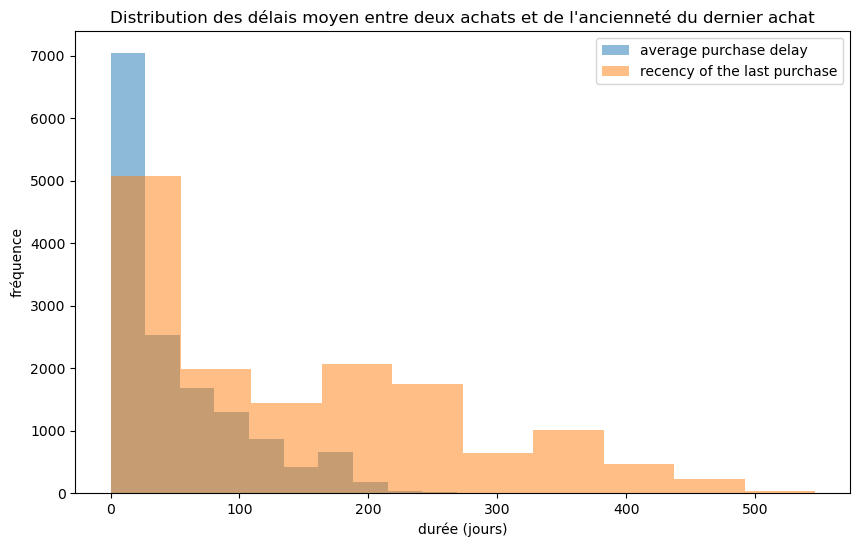

In [180]:
# is pace of purchase a good measure ? 
# we ll compare the avg purchase delay and the purchase date max

plt.figure(figsize = [10,6])

plt.hist(X_test[X_test["avg_purchase_delay"]>0]["avg_purchase_delay"], alpha = 0.5, label = "average purchase delay")
plt.hist(X_test[X_test["avg_purchase_delay"]>0]["purchase_date_max"], alpha=0.5, label = "recency of the last purchase")
plt.legend()
plt.xlabel("durée (jours)")
plt.ylabel("fréquence")
plt.title("Distribution des délais moyen entre deux achats et de l'ancienneté du dernier achat")
plt.show()

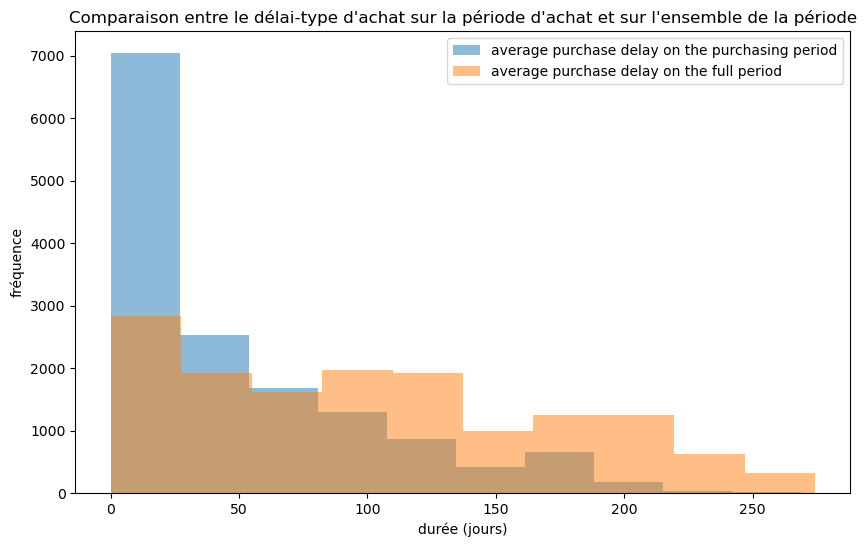

In [199]:
plt.figure(figsize = [10,6])

plt.hist(X_test[X_test["avg_purchase_delay"]>0]["avg_purchase_delay"], alpha = 0.5, label = "average purchase delay on the purchasing period")
plt.hist(X_test[X_test["avg_purchase_delay"]>0]["purchase_date_min"]/X_test[X_test["avg_purchase_delay"]>0]["nb_purchases"], alpha=0.5, label = "average purchase delay on the full period")
plt.legend()
plt.xlabel("durée (jours)")
plt.ylabel("fréquence")
plt.title("Comparaison entre le délai-type d'achat sur la période d'achat et sur l'ensemble de la période")
plt.show()

Il vaut mieux prendre le rythme en considérant purchase date min au dénominateur plutôt que le délai entre le 
1er et le dernier achat

In [192]:
(X_test[X_test["avg_purchase_delay"]>0]["purchase_date_max"]/X_test[X_test["avg_purchase_delay"]>0]["avg_purchase_delay"]).describe()

count    1.473400e+04
mean     9.011960e+07
std      8.222514e+08
min      0.000000e+00
25%      7.194159e-01
50%      3.564579e+00
75%      2.645439e+01
max      1.996151e+10
dtype: float64

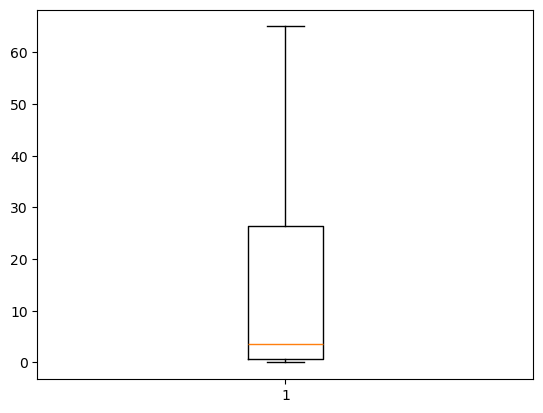

In [196]:
plt.boxplot(X_test[X_test["avg_purchase_delay"]>0]["purchase_date_max"]/X_test[X_test["avg_purchase_delay"]>0]["avg_purchase_delay"], showfliers=False)
plt.show()

In [188]:
X_test[X_test["avg_purchase_delay"]>0]["purchase_date_max"].describe()

count    14734.000000
mean       145.979256
std        123.403697
min          0.000000
25%         38.053773
50%        111.560918
75%        225.056992
max        546.378919
Name: purchase_date_max, dtype: float64

Il est plus pertinent de considérer l'ensemble de la période que de couper à la date du dernier achat \
On définit donc avg purchase delay all comme le délai moyen entre deux achats depuis que le client est 
connu et jusqu'a aujourd'hui

In [202]:
X_test["avg_purchase_delay_all"] = (X_test["purchase_date_min"]/X_test["nb_purchases"]).replace([np.inf, -np.inf], 0)

Il faut aussi étudier le nombre de tickets acheté, pas seulement le nombre d'achats

In [203]:
# on def avg tickets delay de façon similaire à avg purchase delay mais en utilisant plutôt nb tickets

X_test["avg_tickets_delay"] = (X_test["consumption_lifetime"]/X_test["nb_tickets"]).replace([np.inf, -np.inf], 0)
X_test["avg_tickets_delay_all"] = (X_test["purchase_date_min"]/X_test["nb_tickets"]).replace([np.inf, -np.inf], 0)

In [204]:
X_test

nb_tickets  nb_purchases  total_amount  nb_suppliers  \
0             4.0           1.0        100.00           1.0   
1             1.0           1.0         55.00           1.0   
2            17.0           1.0         80.00           1.0   
3             4.0           1.0        120.00           1.0   
4            34.0           2.0        416.00           1.0   
...           ...           ...           ...           ...   
96091         1.0           1.0         67.31           1.0   
96092         1.0           1.0         61.41           1.0   
96093         0.0           0.0          0.00           0.0   
96094         1.0           1.0         79.43           1.0   
96095         0.0           0.0          0.00           0.0   

       vente_internet_max  purchase_date_min  purchase_date_max  \
0                     0.0           5.177187           5.177187   
1                     0.0         426.265613         426.265613   
2                     0.0         436.033437         436.033437   
3                     0.0           5.196412           5.196412   
4                     0.0         478.693148         115.631470   
...                   ...                ...                ...   
96091                 1.0         278.442257         278.442257   
96092                 1.0         189.207373         189.207373   
96093                 0.0         550.000000         550.000000   
96094                 1.0         279.312905         279.312905   
96095                 0.0         550.000000         550.000000   

       nb_tickets_internet  is_email_true  opt_in  ...  nb_campaigns  \
0                      0.0           True   False  ...           0.0   
1                      0.0           True    True  ...           0.0   
2                      0.0           True    True  ...           0.0   
3                      0.0           True   False  ...           0.0   
4                      0.0           True   False  ...           0.0   
...                    ...            ...     ...  ...           ...   
96091                  1.0           True   False  ...          15.0   
96092                  1.0           True   False  ...          12.0   
96093                  0.0           True    True  ...          29.0   
96094                  1.0           True   False  ...          20.0   
96095                  0.0           True   False  ...          31.0   

       nb_campaigns_opened     score  quartile  has_purchased  \
0                      0.0  0.695913         3            0.0   
1                      0.0  0.244205         1            1.0   
2                      0.0  0.279592         2            0.0   
3                      0.0  0.696135         3            0.0   
4                      0.0  0.911844         4            1.0   
...                    ...       ...       ...            ...   
96091                  5.0  0.584680         3            1.0   
96092                  9.0  0.654520         3            0.0   
96093                  3.0  0.116503         1            0.0   
96094                  4.0  0.579827         3            0.0   
96095                  4.0  0.254002         2            0.0   

      consumption_lifetime  avg_purchase_delay  avg_purchase_delay_all  \
0                 0.000000            0.000000                5.177187   
1                 0.000000            0.000000              426.265613   
2                 0.000000            0.000000              436.033437   
3                 0.000000            0.000000                5.196412   
4               363.061678          181.530839              239.346574   
...                    ...                 ...                     ...   
96091             0.000000            0.000000              278.442257   
96092             0.000000            0.000000              189.207373   
96093             0.000000                 NaN                0.000000   
96094             0.000000            0.000000             

In [206]:
X_test[X_test["avg_purchase_delay"]>0].groupby("quartile")[["nb_purchases", "nb_tickets", "consumption_lifetime", 
                                                            "purchase_date_min", "avg_purchase_delay", 
                                                            "avg_purchase_delay_all", "avg_tickets_delay", 
                                                            "avg_tickets_delay_all"]].mean()

nb_purchases  nb_tickets  consumption_lifetime  purchase_date_min  \
quartile                                                                      
1             2.000000    2.714286              0.597093         450.171815   
2             2.592668    5.446707             26.192927         329.247848   
3             3.203764    6.791530             64.785322         266.488673   
4            12.041836   46.274086            306.126700         391.637751   

          avg_purchase_delay  avg_purchase_delay_all  avg_tickets_delay  \
quartile                                                                  
1                   0.298547              225.085907           0.198968   
2                  11.435486              147.533946           5.992807   
3                  25.490483              107.753468          14.307458   
4                  68.659817               92.058104          38.736644   

          avg_tickets_delay_all  
quartile                         
1                    174.041855  
2                     88.757091  
3                     65.942338  
4                     53.575899

Le délai moyen entre deux achats sur l'ensemble de la période

In [210]:
X_test[(X_test["avg_purchase_delay"]>0) & (X_test["quartile"]=="2")]

nb_tickets  nb_purchases  total_amount  nb_suppliers  \
30            3.0           3.0         35.00           1.0   
37            6.0           2.0        105.00           1.0   
38            4.0           2.0        145.50           1.0   
51            4.0           4.0        276.00           1.0   
67           11.0           2.0        210.00           1.0   
...           ...           ...           ...           ...   
71408         2.0           2.0         62.51           1.0   
71439         2.0           2.0         28.54           1.0   
74420         2.0           2.0        115.90           1.0   
79490         2.0           2.0         73.06           1.0   
89618         2.0           2.0        134.66           1.0   

       vente_internet_max  purchase_date_min  purchase_date_max  \
30                    0.0         219.530451         193.553044   
37                    0.0         422.518935         422.474444   
38                    1.0         469.053773         337.012106   
51                    1.0         317.012106         294.012106   
67                    0.0         373.627303         255.476065   
...                   ...                ...                ...   
71408                 1.0         490.113715         489.507940   
71439                 1.0         505.334005         505.324873   
74420                 0.0         522.320521         522.318229   
79490                 1.0         541.175509         521.153692   
89618                 1.0         527.497685         506.694931   

       nb_tickets_internet  is_email_true  opt_in  ...  nb_campaigns  \
30                     0.0           True    True  ...           0.0   
37                     0.0           True    True  ...           0.0   
38                     4.0           True    True  ...           0.0   
51                     4.0           True    True  ...           0.0   
67                     0.0           True    True  ...           0.0   
...                    ...            ...     ...  ...           ...   
71408                  2.0           True   False  ...          12.0   
71439                  2.0           True   False  ...          16.0   
74420                  0.0           True   False  ...          35.0   
79490                  2.0           True   False  ...          36.0   
89618                  2.0           True   False  ...          30.0   

       nb_campaigns_opened     score  quartile  has_purchased  \
30                     0.0  0.387177         2            1.0   
37                     0.0  0.258480         2            0.0   
38                     0.0  0.424641         2            1.0   
51                     0.0  0.353000         2            0.0   
67                     0.0  0.463581         2            0.0   
...                    ...       ...       ...            ...   
71408                  6.0  0.469953         2            0.0   
71439                 13.0  0.499401         2            0.0   
74420                  9.0  0.453181         2            1.0   
79490                  4.0  0.463122         2            0.0   
89618                  0.0  0.449862         2            0.0   

      consumption_lifetime  avg_purchase_delay  avg_purchase_delay_all  \
30               25.977407            8.659136               73.176817   
37                0.044491            0.022245              211.259468   
38              132.041667           66.020833              234.526887   
51               23.000000            5.750000               79.253027   
67              118.151238           59.075619              186.813652   
...                    ...                 ...                     ...   
71408             0.605775            0.302888              245.056858   
71439             0.009132            0.004566              252.667002   
74420             0.002292            0.001146              261.160260   
79490            20.021817           10.010909             

In [214]:
X_test[(X_test["avg_purchase_delay"]>0) & (X_test["purchase_date_min"]<10)].head(20)

nb_tickets  nb_purchases  total_amount  nb_suppliers  \
136          2.0           2.0          50.0           1.0   
187          3.0           2.0         117.0           1.0   
229          4.0           2.0         196.0           1.0   
312          4.0           2.0         200.0           1.0   
439          4.0           2.0         156.0           1.0   
613          4.0           2.0         156.0           1.0   
713          4.0           2.0         100.0           1.0   
967          2.0           2.0          60.0           1.0   
1042         2.0           2.0         106.0           1.0   
1096         4.0           2.0         110.0           1.0   
1124         2.0           2.0          50.0           1.0   
1451         2.0           2.0          60.0           1.0   
1728         4.0           2.0         100.0           1.0   
1740         2.0           2.0          60.0           1.0   
1843         2.0           2.0         102.0           1.0   
1862         2.0           2.0         106.0           1.0   
1984         2.0           2.0          88.0           1.0   
2041         3.0           2.0         147.0           1.0   
2115         3.0           2.0          75.0           1.0   
2384         4.0           2.0         196.0           1.0   

      vente_internet_max  purchase_date_min  purchase_date_max  \
136                  0.0           5.179282           4.441181   
187                  0.0           5.190961           4.422014   
229                  0.0           5.144676           5.123021   
312                  0.0           5.180069           5.061979   
439                  0.0           5.167558           5.112234   
613                  0.0           3.285567           2.801887   
713                  0.0           5.183241           5.060972   
967                  0.0           3.251076           3.127894   
1042                 0.0           5.140903           5.133646   
1096                 0.0           5.190764           4.646551   
1124                 0.0           5.192303           5.144618   
1451                 0.0           5.126782           5.118449   
1728                 0.0           5.137326           4.958299   
1740                 0.0           5.183495           5.176933   
1843                 0.0           5.184803           5.180162   
1862                 0.0           5.197801           5.191470   
1984                 0.0           5.189468           5.182257   
2041                 0.0           4.597095           4.373079   
2115                 0.0           5.182986           5.129433   
2384                 0.0           5.171771           4.604873   

      nb_tickets_internet  is_email_true  opt_in  ...  nb_campaigns  \
136                   0.0           True   False  ...           0.0   
187                   0.0           True   False  ...           0.0   
229                   0.0           True   False  ...           0.0   
312                   0.0           True   False  ...           0.0   
439                   0.0           True   False  ...           0.0   
613                   0.0           True    True  ...           0.0   
713                   0.0           True   False  ...           0.0   
967                   0.0           True   False  ...           0.0   
1042                  0.0           True   False  ...           0.0   
1096                  0.0           True   False  ...           0.0   
1124                  0.0           True   False  ...           0.0   
1451                  0.0           True   False  ...           0.0   
1728                  0.0           True   False  ...           0.0   
1740                  0.0           True   False  ...           0.0   
1843                  0.0           True   False  ...           0.0   
1862                  0.0           True   False  ...           0.0   
1984                  0.0           True   False  ...           0.0   
2041                  0.0           Tr

In [217]:
y_test.sum()

y_has_purchased    13690.0
dtype: float64

In [218]:
X_test["score"].sum()

36092.22480054577

In [241]:
X_test[X_test["quartile"]=="3"]["has_purchased"].mean()

0.20933232507450736

Autre méthode \
On considère la durée totale sur laquelle les features ont été observées (1 an et demi) sans se soucier de la 
date du 1er achat. 
Et on extrapole le rythme d'achat en considérant que le client devrait acheter nb_tickets/1.5 tickets durant l'année à venir. 

In [240]:
period_duration_years = 1.5

expected_tickets_purchased = X_test["nb_tickets"]/period_duration_years
expected_amount = X_test["total_amount"]/period_duration_years

In [297]:
X_test

nb_tickets  nb_purchases  total_amount  nb_suppliers  \
0             4.0           1.0        100.00           1.0   
1             1.0           1.0         55.00           1.0   
2            17.0           1.0         80.00           1.0   
3             4.0           1.0        120.00           1.0   
4            34.0           2.0        416.00           1.0   
...           ...           ...           ...           ...   
96091         1.0           1.0         67.31           1.0   
96092         1.0           1.0         61.41           1.0   
96093         0.0           0.0          0.00           0.0   
96094         1.0           1.0         79.43           1.0   
96095         0.0           0.0          0.00           0.0   

       vente_internet_max  purchase_date_min  purchase_date_max  \
0                     0.0           5.177187           5.177187   
1                     0.0         426.265613         426.265613   
2                     0.0         436.033437         436.033437   
3                     0.0           5.196412           5.196412   
4                     0.0         478.693148         115.631470   
...                   ...                ...                ...   
96091                 1.0         278.442257         278.442257   
96092                 1.0         189.207373         189.207373   
96093                 0.0         550.000000         550.000000   
96094                 1.0         279.312905         279.312905   
96095                 0.0         550.000000         550.000000   

       nb_tickets_internet  is_email_true  opt_in  ...  quartile  \
0                      0.0           True   False  ...         3   
1                      0.0           True    True  ...         1   
2                      0.0           True    True  ...         2   
3                      0.0           True   False  ...         3   
4                      0.0           True   False  ...         4   
...                    ...            ...     ...  ...       ...   
96091                  1.0           True   False  ...         3   
96092                  1.0           True   False  ...         3   
96093                  0.0           True    True  ...         1   
96094                  1.0           True   False  ...         3   
96095                  0.0           True   False  ...         2   

       has_purchased  consumption_lifetime  avg_purchase_delay  \
0                0.0              0.000000            0.000000   
1                1.0              0.000000            0.000000   
2                0.0              0.000000            0.000000   
3                0.0              0.000000            0.000000   
4                1.0            363.061678          181.530839   
...              ...                   ...                 ...   
96091            1.0              0.000000            0.000000   
96092            0.0              0.000000            0.000000   
96093            0.0              0.000000                 NaN   
96094            0.0              0.000000            0.000000   
96095            0.0              0.000000                 NaN   

       avg_purchase_delay_all avg_tickets_delay  avg_tickets_delay_all  \
0                    5.177187          0.000000               1.294297   
1                  426.265613          0.000000             426.265613   
2                  436.033437          0.000000              25.649026   
3                    5.196412          0.000000               1.299103   
4                  239.346574         10.678285              14.079210   
...                       ...               ...                    ...   
96091              278.442257          0.000000             278.442257   
96092              189.207373          0.000000             189.207373   
96093                0.000000               NaN               0.000000   
96094              279.312905          0.000000             279.312905   
96095                

Estimation de l'overshoot : méthode plus rigoureuse 

on étudie le rapport entre le score et has purchased
plus exactement entre score/(1-score) et has_purchased/(1-has_purchased) - permet de coller à structure du logit

In [301]:
score_odd_ratio_quartile = X_test.groupby("quartile")["score"].mean()/(1-X_test.groupby("quartile")["score"].mean())
score_odd_ratio_quartile

quartile
1    0.203706
2    0.564483
3    1.679424
4    9.209851
Name: score, dtype: float64

In [302]:
y_odd_ratio_quartile = X_test.groupby("quartile")["has_purchased"].mean()/(1-X_test.groupby("quartile")["has_purchased"].mean())
y_odd_ratio_quartile

quartile
1    0.027517
2    0.133083
3    0.264754
4    1.998944
Name: has_purchased, dtype: float64

### PB : a-t-on le même résultat de calcul du biais sur X_train et y_train ?

In [478]:
X_test

nb_tickets  nb_purchases  total_amount  nb_suppliers  \
0             4.0           1.0        100.00           1.0   
1             1.0           1.0         55.00           1.0   
2            17.0           1.0         80.00           1.0   
3             4.0           1.0        120.00           1.0   
4            34.0           2.0        416.00           1.0   
...           ...           ...           ...           ...   
96091         1.0           1.0         67.31           1.0   
96092         1.0           1.0         61.41           1.0   
96093         0.0           0.0          0.00           0.0   
96094         1.0           1.0         79.43           1.0   
96095         0.0           0.0          0.00           0.0   

       vente_internet_max  purchase_date_min  purchase_date_max  \
0                     0.0           5.177187           5.177187   
1                     0.0         426.265613         426.265613   
2                     0.0         436.033437         436.033437   
3                     0.0           5.196412           5.196412   
4                     0.0         478.693148         115.631470   
...                   ...                ...                ...   
96091                 1.0         278.442257         278.442257   
96092                 1.0         189.207373         189.207373   
96093                 0.0         550.000000         550.000000   
96094                 1.0         279.312905         279.312905   
96095                 0.0         550.000000         550.000000   

       nb_tickets_internet  is_email_true  opt_in  ...  decile  \
0                      0.0           True   False  ...       6   
1                      0.0           True    True  ...       2   
2                      0.0           True    True  ...       2   
3                      0.0           True   False  ...       6   
4                      0.0           True   False  ...       9   
...                    ...            ...     ...  ...     ...   
96091                  1.0           True   False  ...       5   
96092                  1.0           True   False  ...       6   
96093                  0.0           True    True  ...       1   
96094                  1.0           True   False  ...       5   
96095                  0.0           True   False  ...       2   

       overshoot_coeff  ajusted_score  odd_ratio  test_adjusted_score_2  \
0             3.294104       0.211260   2.288530               0.533640   
1             3.826401       0.063821   0.323109               0.139085   
2             3.826401       0.073069   0.388102               0.162515   
3             3.294104       0.211328   2.290940               0.533902   
4             1.268598       0.718781  10.343538               0.837972   
...                ...            ...        ...                    ...   
96091         3.260982       0.179296   1.407779               0.413108   
96092         3.294104       0.198694   1.894523               0.486458   
96093        17.863019       0.006522   0.131865               0.061854   
96094         3.260982       0.177808   1.379973               0.408279   
96095         3.826401       0.066382   0.340487               0.145477   

      score_adjusted  nb_tickets_projected  total_amount_projected  \
0           0.274689              2.666667               66.666667   
1           0.050756              0.666667               36.666667   
2           0.060349             11.333333               53.333333   
3           0.274899              2.666667               80.000000   
4           0.631228             22.666667              277.333333   
...              ...                   ...                     ...   
96091       0.188948              0.666667               44.873333   
96092       0.238685              0.666667               40.940000   
96093       0.021356              0.000000                0.000000   
96094       0.185910              0.666667         

In [479]:
y_pred_prob_train = logit_grid.predict_proba(X_train)[:, 1]


In [484]:
# globalement, on a toujours une somme de scores 3 fois supérieure (même si le biais semble atténué)
print("somme des scores calculés sur X train : ",y_pred_prob_train.sum())
print("somme des y train : ", y_train.sum()["y_has_purchased"])

somme des scores calculés sur X train :  84127.81461345348
somme des y train :  32154.0


In [493]:
X_train["score"] = y_pred_prob_train
# X_train["odd_ratio"] = X_train["score"]/(1-X_train["score"])
X_train

nb_tickets  nb_purchases  total_amount  nb_suppliers  \
0              2.0           1.0         60.00           1.0   
1              8.0           3.0        140.00           1.0   
2              2.0           1.0         50.00           1.0   
3              3.0           1.0         90.00           1.0   
4              2.0           1.0         78.00           1.0   
...            ...           ...           ...           ...   
224208         0.0           0.0          0.00           0.0   
224209         1.0           1.0         20.00           1.0   
224210         0.0           0.0          0.00           0.0   
224211         1.0           1.0         97.11           1.0   
224212         0.0           0.0          0.00           0.0   

        vente_internet_max  purchase_date_min  purchase_date_max  \
0                      0.0         355.268981         355.268981   
1                      0.0         373.540289         219.262269   
2                      0.0           5.202442           5.202442   
3                      0.0           5.178958           5.178958   
4                      0.0           5.174039           5.174039   
...                    ...                ...                ...   
224208                 0.0         550.000000         550.000000   
224209                 1.0         392.501030         392.501030   
224210                 0.0         550.000000         550.000000   
224211                 1.0         172.334074         172.334074   
224212                 0.0         550.000000         550.000000   

        nb_tickets_internet  is_email_true  opt_in  gender_female  \
0                       0.0           True   False              0   
1                       0.0           True   False              0   
2                       0.0           True   False              0   
3                       0.0           True   False              0   
4                       0.0           True   False              1   
...                     ...            ...     ...            ...   
224208                  0.0           True   False              0   
224209                  1.0           True   False              0   
224210                  0.0           True    True              0   
224211                  1.0           True   False              0   
224212                  0.0           True   False              0   

        gender_male  nb_campaigns  nb_campaigns_opened     score  odd_ratio  
0                 1           0.0                  0.0  0.493834   0.975638  
1                 1           0.0                  0.0  0.722704   2.606253  
2                 1           0.0                  0.0  0.689866   2.224409  
3                 1           0.0                  0.0  0.693078   2.258158  
4                 0           0.0                  0.0  0.690209   2.227980  
...             ...           ...                  ...       ...        ...  
224208            1          34.0                  3.0  0.250218   0.333721  
224209            1          23.0                  6.0  0.524745   1.104135  
224210            1           8.0                  4.0  0.117175   0.132728  
224211            1          13.0                  5.0  0.643851   1.807814  
224212            1           4.0                  4.0  0.250170   0.333636  

[224213 rows x 16 columns]

In [491]:
X_train["odd_ratio"][X_train["odd_ratio"]<np.inf].describe()

count    2.241790e+05
mean     5.824134e+10
std      1.462083e+13
min      1.207494e-01
25%      1.476621e-01
50%      3.338869e-01
75%      1.427047e+00
max      4.503600e+15
Name: odd_ratio, dtype: float64

In [494]:
# on utilise le second score comme valeur de remplacement quand score = 1
X_train_second_score = X_train["score"][X_train["score"]<1].max()

X_train["score"] = X_train["score"].apply(lambda x : X_train_second_score if x==1 else x)
X_train

nb_tickets  nb_purchases  total_amount  nb_suppliers  \
0              2.0           1.0         60.00           1.0   
1              8.0           3.0        140.00           1.0   
2              2.0           1.0         50.00           1.0   
3              3.0           1.0         90.00           1.0   
4              2.0           1.0         78.00           1.0   
...            ...           ...           ...           ...   
224208         0.0           0.0          0.00           0.0   
224209         1.0           1.0         20.00           1.0   
224210         0.0           0.0          0.00           0.0   
224211         1.0           1.0         97.11           1.0   
224212         0.0           0.0          0.00           0.0   

        vente_internet_max  purchase_date_min  purchase_date_max  \
0                      0.0         355.268981         355.268981   
1                      0.0         373.540289         219.262269   
2                      0.0           5.202442           5.202442   
3                      0.0           5.178958           5.178958   
4                      0.0           5.174039           5.174039   
...                    ...                ...                ...   
224208                 0.0         550.000000         550.000000   
224209                 1.0         392.501030         392.501030   
224210                 0.0         550.000000         550.000000   
224211                 1.0         172.334074         172.334074   
224212                 0.0         550.000000         550.000000   

        nb_tickets_internet  is_email_true  opt_in  gender_female  \
0                       0.0           True   False              0   
1                       0.0           True   False              0   
2                       0.0           True   False              0   
3                       0.0           True   False              0   
4                       0.0           True   False              1   
...                     ...            ...     ...            ...   
224208                  0.0           True   False              0   
224209                  1.0           True   False              0   
224210                  0.0           True    True              0   
224211                  1.0           True   False              0   
224212                  0.0           True   False              0   

        gender_male  nb_campaigns  nb_campaigns_opened     score  odd_ratio  
0                 1           0.0                  0.0  0.493834   0.975638  
1                 1           0.0                  0.0  0.722704   2.606253  
2                 1           0.0                  0.0  0.689866   2.224409  
3                 1           0.0                  0.0  0.693078   2.258158  
4                 0           0.0                  0.0  0.690209   2.227980  
...             ...           ...                  ...       ...        ...  
224208            1          34.0                  3.0  0.250218   0.333721  
224209            1          23.0                  6.0  0.524745   1.104135  
224210            1           8.0                  4.0  0.117175   0.132728  
224211            1          13.0                  5.0  0.643851   1.807814  
224212            1           4.0                  4.0  0.250170   0.333636  

[224213 rows x 16 columns]

In [498]:
X_train["score"].max()

0.9999999999999998

In [499]:
X_train["odd_ratio"] = X_train["score"]/(1-X_train["score"])
X_train["odd_ratio"].describe()

count    2.242130e+05
mean     7.411652e+11
std      5.734858e+13
min      1.207494e-01
25%      1.476621e-01
50%      3.338869e-01
75%      1.427525e+00
max      4.503600e+15
Name: odd_ratio, dtype: float64

In [500]:
def obj_function_X_train(bias) :
    obj = sum([adjusted_score(element, bias) for element in X_train["odd_ratio"]]) # - y_test.sum()["y_has_purchased"]
    return obj

In [501]:
# minimization

from scipy.optimize import minimize


y_train_sum = y_train.sum()["y_has_purchased"]
initial_guess = 6
estimated_biais_train = minimize(lambda bias : (obj_function_X_train(bias)-y_train_sum)**2 ,
initial_guess , method = "BFGS")

In [502]:
# biais de 5.95 contre 6.04 pour le test set, OK
print(f"bias estimated on train set: {estimated_biais_train.x[0]}")

bias estimated on train set: 5.947447991192572


### construction d'une fonction de généralisation de la méthode de calcul du biais

Le biais est calculé de la façon suivante. 
En notant $\hat{p(x_i)}$ le score calculé et $p(x_i)$ le vrai score (sans biais), et $\beta$ le logarithme du biais, on a : \
$\ln{\frac{\hat{p(x_i)}}{1-\hat{p(x_i)}}} = \beta + \ln{\frac{p(x_i)}{1-p(x_i)}}$ \
$ \frac{\hat{p(x_i)}}{1-\hat{p(x_i)}} = \exp(\beta) . \frac{p(x_i)}{1-p(x_i)} $ \
Ce qu'on appelle biais et qu'on estime dans le code par la suite est : $B=\exp(\beta) $. Les probabilités ne sont donc pas biaisées si $B=1$. Il y a surestimation si $B>1$. 

On cherche le B qui permette d'ajuster les probabilités de telle sorte que la somme des scores soit égale à la somme des y_has_purchased. Cela revient à résoudre : 

\begin{equation}
\sum_{i}{\frac{\frac{\hat{p(x_i)}}{1-\hat{p(x_i)}}}{B+\frac{\hat{p(x_i)}}{1-\hat{p(x_i)}}}} = \sum_{i}{Y_i}
\end{equation}

C'est ce que fait la fonction find_bias

In [733]:
def adjusted_score(odd_ratio, bias) :
    adjusted_score = odd_ratio/(bias+odd_ratio)
    return adjusted_score

In [734]:
# fonction qui prend un vecteur en entrée et remplace les 1 par la seconde plus grande valeur
# permet de remplacer les 1 par une valeur de score très proche, et d'ainsi éviter des odd ratio infinis

def adjust_score_1(score) :
    second_best_score = np.array([element for element in score if element !=1]).max()
    new_score = np.array([element if element!=1 else second_best_score for element in score])
    
    return new_score


In [735]:
def odd_ratio(score) :
    return score / (1 - score)

In [768]:
# definition of a function that automatically detects the bias

def find_bias(odd_ratios, y_objective, initial_guess=6) :
    """
    results = minimize(lambda bias : (sum([adjusted_score(element, bias) for element in list(odd_ratios)]) - y_objective)**2 ,
    initial_guess , method = "BFGS")

    estimated_bias = results.x[0]
    """

    # faster method
    bias_estimated = fsolve(lambda bias : sum([adjusted_score(element, bias) for element in list(odd_ratios)]) - y_objective, x0=6)
 
    return bias_estimated[0]

In [761]:
# autre méthode : avec fsolve

from scipy.optimize import fsolve

bias_estimated = fsolve(lambda bias : sum([adjusted_score(element, bias) for element in list(odd_ratios)]) - y_objective, x0=6)
bias_estimated

array([6.0428265])

In [760]:
import time

In [763]:
# comparaison du temps pris par les deux opérations

temps_debut = time.time()
bias_estimated_1 = fsolve(lambda bias : sum([adjusted_score(element, bias) for element in list(odd_ratios)]) - y_objective, x0=6)
temps_fin = time.time()

temps_ecoule = temps_fin - temps_debut
print("résultat : ",bias_estimated_1)
print("tps de calcul", temps_ecoule)

temps_debut = time.time()
bias_estimated_2 = minimize(lambda bias : (sum([adjusted_score(element, bias) for element in list(odd_ratios)]) - y_objective)**2 ,
    x0=6 , method = "BFGS").x[0]
temps_fin = time.time()

temps_ecoule = temps_fin - temps_debut
print("résultat : ",bias_estimated_2)
print("tps de calcul", temps_ecoule)

résultat :  [6.0428265]
tps de calcul 2.112041473388672
résultat :  6.042826489667565
tps de calcul 3.9603891372680664


In [755]:
odd_ratios

array([2.28853049, 0.3231094 , 0.38810178, ..., 0.13186529, 1.37997272,
       0.34048672])

In [749]:
sum([adjusted_score(element, 1) for element in list(odd_ratios)]) # - y_objective

36092.2248005385

In [704]:
[element for element in np.array([0,1])]

[0, 1]

In [544]:
# the function works well !!

bias_train_set = find_bias(odd_ratios = X_train["odd_ratio"], y_objective = y_train_sum, initial_guess = 6)
bias_train_set

5.947447991192572

In [716]:
odd_ratio = odd_ratio(adjust_score_1(X_test["score"]))
odd_ratio

array([2.28853049, 0.3231094 , 0.38810178, ..., 0.13186529, 1.37997272,
       0.34048672])

In [751]:
# definition of the values for the pb

new_score = adjust_score_1(X_test["score"])

odd_ratios = odd_ratio(np.array(new_score))

y_objective = y_test["y_has_purchased"].sum()

In [752]:
new_score, odd_ratios, y_objective

(array([0.69591281, 0.2442046 , 0.27959173, ..., 0.11650264, 0.57982712,
        0.25400231]),
 array([2.28853049, 0.3231094 , 0.38810178, ..., 0.13186529, 1.37997272,
        0.34048672]),
 13690.0)

In [769]:
# computation with the function defined

bias_test_set = find_bias(odd_ratios = odd_ratios, 
                           y_objective = y_objective,
                           initial_guess=6)
bias_test_set

6.042826497117542

In [770]:
biais_train_set = find_bias(odd_ratios = odd_ratio(adjust_score_1(X_train["score"])), 
                           y_objective = y_train["y_has_purchased"].sum(),
                           initial_guess=6)
biais_train_set

5.947447998640124

In [772]:
bias_train_set

5.947447991192572

In [776]:
# différence des beta (log du biais)
print("betâ test - betâ train = ",np.log(bias_test_set/bias_train_set))

betâ test - betâ train =  0.015909647078591174


## Random forest

In [26]:
X_train_subsample

nb_tickets  nb_purchases  total_amount  nb_suppliers  \
43000          0.0           0.0           0.0           0.0   
183923         0.0           0.0           0.0           0.0   
97373          0.0           0.0           0.0           0.0   
66956          7.0           2.0         254.0           1.0   
116487         0.0           0.0           0.0           0.0   
...            ...           ...           ...           ...   
83146          1.0           1.0          35.0           1.0   
223586         0.0           0.0           0.0           0.0   
56489          0.0           0.0           0.0           0.0   
141236         0.0           0.0           0.0           0.0   
6999           2.0           1.0          20.0           1.0   

        vente_internet_max  purchase_date_min  purchase_date_max  \
43000                  0.0         550.000000         550.000000   
183923                 0.0         550.000000         550.000000   
97373                  0.0         550.000000         550.000000   
66956                  1.0         378.343062         370.453947   
116487                 0.0         550.000000         550.000000   
...                    ...                ...                ...   
83146                  1.0          37.474040          37.474040   
223586                 0.0         550.000000         550.000000   
56489                  0.0         550.000000         550.000000   
141236                 0.0         550.000000         550.000000   
6999                   0.0         171.446921         171.446921   

        nb_tickets_internet  is_email_true  opt_in  gender_female  \
43000                   0.0           True    True              0   
183923                  0.0           True    True              0   
97373                   0.0           True   False              0   
66956                   7.0           True   False              0   
116487                  0.0           True   False              1   
...                     ...            ...     ...            ...   
83146                   1.0           True   False              0   
223586                  0.0           True    True              0   
56489                   0.0           True    True              0   
141236                  0.0           True   False              0   
6999                    0.0           True    True              1   

        gender_male  nb_campaigns  nb_campaigns_opened  
43000             1          14.0                 12.0  
183923            1          19.0                 11.0  
97373             0           7.0                  2.0  
66956             1           0.0                  0.0  
116487            0           5.0                  0.0  
...             ...           ...                  ...  
83146             1           9.0                  3.0  
223586            1          23.0                  1.0  
56489             1           4.0                  0.0  
141236            1           6.0                  0.0  
6999              0           0.0                  0.0  

[10000 rows x 14 columns]

### Preprocessing

In [10]:
# no need to standardize variables in a random forest
# we just encode categorical variables

categorical_features = ['opt_in', 'is_email_true']  

# Transformer for the categorical features
categorical_transformer = Pipeline(steps=[
    #("imputer", SimpleImputer(strategy="most_frequent")),  # Impute missing values with the most frequent
    ("onehot", OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preproc = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_features)
    ]
)

In [16]:
preproc

ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['opt_in', 'is_email_true'])])

### Pipeline

In [ ]:
# Define models and parameters for GridSearch
model = {
        'model': RandomForestClassifier(),
        'params': {
            'randforest__n_estimators': [100, 150, 200, 250, 300],
            'randforest__max_depth': [None, 15, 20, 25, 30, 35, 40],
        }
    }

# Test each model using GridSearchCV
pipe = Pipeline(steps=[('preprocessor', preproc), ('randforest', model['model'])])
clf = GridSearchCV(pipe, model['params'], cv=3)
clf.fit(X_train, y_train)

print(f"Model: {model['model']}")
print(f"Best parameters: {clf.best_params_}")
print('Best classification accuracy in train is: {}'.format(clf.best_score_))
print('Classification accuracy on test is: {}'.format(clf.score(X_test, y_test)))
print("------")

In [43]:
# Pipeline - on joue sur : max_depth

param_grid = {"random_forest__max_depth" : [None, 10, 20, 40, 50, 60]}

pipeline = Pipeline(steps=[
    ('preprocessor', preproc),
    ('random_forest', RandomForestClassifier(bootstrap = False, class_weight = weight_dict,
                                            ))  
])

pipeline.set_output(transform="pandas")

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['opt_in',
                                                   'is_email_true'])])),
                ('random_forest',
                 RandomForestClassifier(class_weight={0.0: 0.5837086520288036,
                                                      1.0: 3.486549107420539}))])

In [14]:
RandomForestClassifier().__dict__

{'estimator': DecisionTreeClassifier(),
 'n_estimators': 100,
 'estimator_params': ('criterion',
  'max_depth',
  'min_samples_split',
  'min_samples_leaf',
  'min_weight_fraction_leaf',
  'max_features',
  'max_leaf_nodes',
  'min_impurity_decrease',
  'random_state',
  'ccp_alpha',
  'monotonic_cst'),
 'bootstrap': True,
 'oob_score': False,
 'n_jobs': None,
 'random_state': None,
 'verbose': 0,
 'warm_start': False,
 'class_weight': None,
 'max_samples': None,
 'criterion': 'gini',
 'max_depth': None,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'min_weight_fraction_leaf': 0.0,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'monotonic_cst': None,
 'ccp_alpha': 0.0}

In [44]:
# pipeline on the subsample

random_forest_grid = GridSearchCV(pipeline, param_grid, cv=3, scoring = f1_scorer #, error_score="raise"
                         )

random_forest_grid

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['opt_in',
                                                                          'is_email_true'])])),
                                       ('random_forest',
                                        RandomForestClassifier(class_weight={0.0: 0.5837086520288036,
                                                                             1.0: 3.486549107420539}))]),
             param_grid={'random_forest__max_depth': [None, 10, 20, 40, 50,
                                                      60]},
             scoring=make_scorer(f1_score, response_method='predict'))

In [45]:
# run the pipeline on the full sample

random_forest_grid.fit(X_train, y_train)

# print results
print('Returned hyperparameter: {}'.format(random_forest_grid.best_params_))
print('Best classification F1 score in train is: {}'.format(random_forest_grid.best_score_))
print('Classification F1 score on test is: {}'.format(random_forest_grid.score(X_test, y_test)))

/opt/mamba/lib/python3.11/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/mamba/lib/python3.11/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/mamba/lib/python3.11/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/mamba/lib/python3.11/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example usi

Returned hyperparameter: {'random_forest__max_depth': None}
Best classification F1 score in train is: 0.33107422141513826
Classification F1 score on test is: 0.31752789604029275


In [33]:
random_forest_grid.__dict__

{'scoring': make_scorer(f1_score, response_method='predict'),
 'estimator': Pipeline(steps=[('preprocessor',
                  ColumnTransformer(transformers=[('cat',
                                                   Pipeline(steps=[('onehot',
                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                  sparse_output=False))]),
                                                   ['opt_in',
                                                    'is_email_true'])])),
                 ('random_forest',
                  RandomForestClassifier(bootstrap=False,
                                         class_weight={0.0: 0.5837086520288036,
                                                       1.0: 3.486549107420539}))]),
 'n_jobs': None,
 'refit': True,
 'cv': 3,
 'verbose': 0,
 'pre_dispatch': '2*n_jobs',
 'error_score': nan,
 'return_train_score': False,
 'param_gr

In [46]:
# print results for the best model

y_pred = random_forest_grid.predict(X_test)

# Calculate the F1 score
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {acc}")

f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")

recall = recall_score(y_test, y_pred)
print(f"Recall Score: {recall}")

Accuracy Score: 0.48955211455211456
F1 Score: 0.31752789604029275
Recall Score: 0.8335281227173119


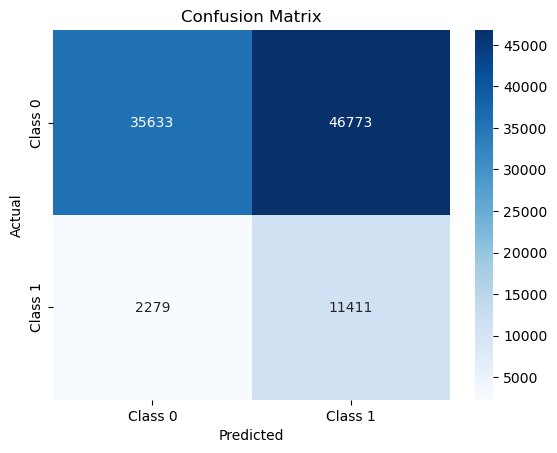

In [47]:
# confusion matrix 

draw_confusion_matrix(y_test, y_pred)

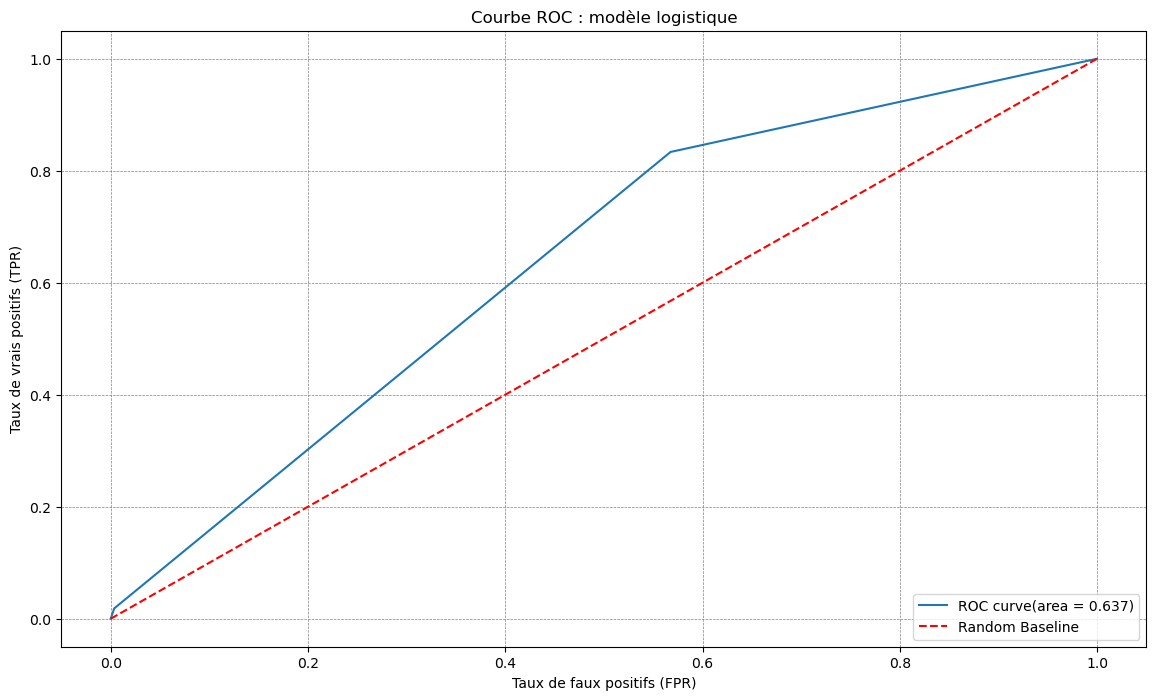

In [48]:
# ROC curve

# Calcul des taux de faux positifs (FPR) et de vrais positifs (TPR)
y_pred_prob = random_forest_grid.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)

# Calcul de l'aire sous la courbe ROC (AUC)
roc_auc = auc(fpr, tpr)

plt.figure(figsize = (14, 8))
plt.plot(fpr, tpr, label="ROC curve(area = %0.3f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="red",label="Random Baseline", linestyle="--")
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC : random forest')
plt.legend(loc="lower right")
plt.show()

## Naive Bayes 

In [219]:
clf = GaussianNB()
clf.fit(X_train, y_train)

GaussianNB()

In [234]:
# print results for the best model

y_pred = clf.predict(X_test)

# Calculate the F1 score
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {acc}")

f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")

recall = recall_score(y_test, y_pred)
print(f"Recall Score: {recall}")

Accuracy Score: 0.8780906593406593
F1 Score: 0.3673381217259815
Recall Score: 0.24842951059167276


In [239]:
# le bayes naif sous-estime les probas d'achat (les autres modèles surestiment pr avoir un bon recall) w
print(f"somme des probas de y prédites : {y_pred_prob.sum()}")
print(f"nombre de y valant 1 : {y_test.sum()}")

somme des probas de y prédites : 4889.8913137503505
nombre de y valant 1 : y_has_purchased    13690.0
dtype: float64


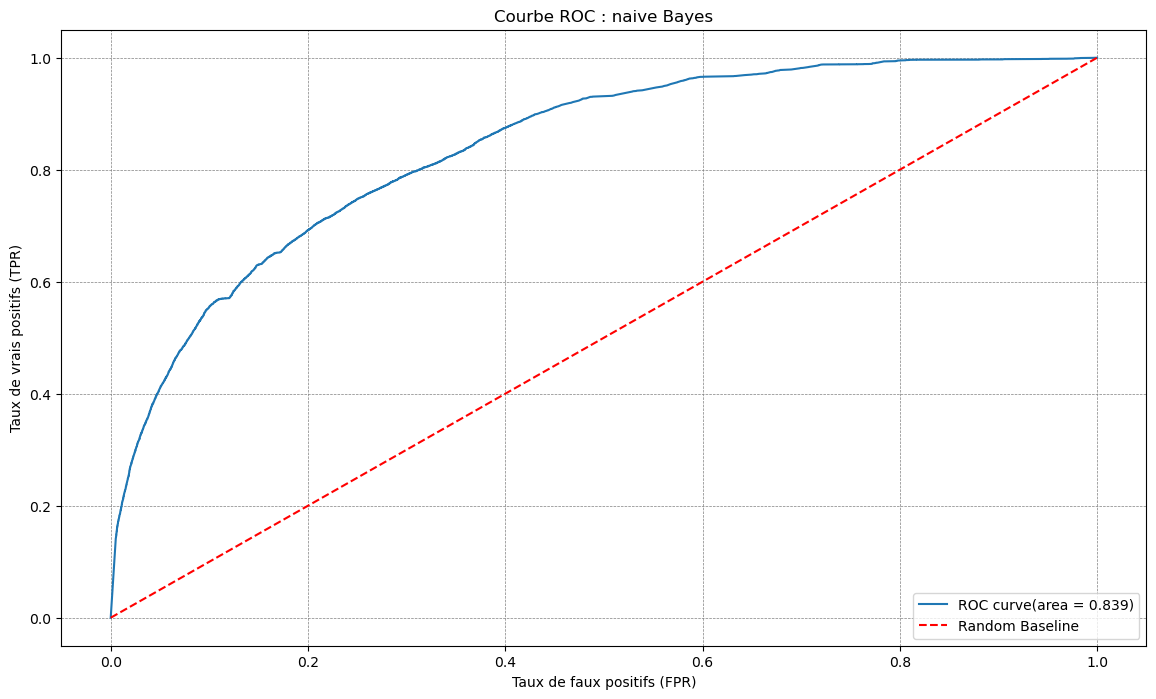

In [236]:
# ROC curve

# Calcul des taux de faux positifs (FPR) et de vrais positifs (TPR)
y_pred_prob = clf.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)

# Calcul de l'aire sous la courbe ROC (AUC)
roc_auc = auc(fpr, tpr)

plt.figure(figsize = (14, 8))
plt.plot(fpr, tpr, label="ROC curve(area = %0.3f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="red",label="Random Baseline", linestyle="--")
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC : naive Bayes')
plt.legend(loc="lower right")
plt.show()

/opt/mamba/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


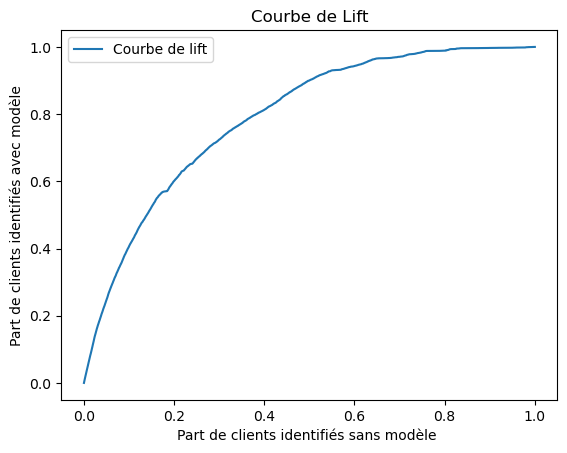

In [13]:
# utilisation d'une métrique plus adaptée aux modèles de marketing : courbe de lift

# Tri des prédictions de probabilités et des vraies valeurs
sorted_indices = np.argsort(y_pred_prob)[::-1]
y_pred_prob_sorted = y_pred_prob[sorted_indices]
y_test_sorted = y_test.iloc[sorted_indices]

# Calcul du gain cumulatif
cumulative_gain = np.cumsum(y_test_sorted) / np.sum(y_test_sorted)

# Tracé de la courbe de lift
plt.plot(np.linspace(0, 1, len(cumulative_gain)), cumulative_gain, label='Courbe de lift')
plt.xlabel('Part de clients identifiés sans modèle ')
plt.ylabel('Part de clients identifiés avec modèle')
plt.title('Courbe de Lift')
plt.legend()
plt.show()

## From model to segmentation

(array([9.0362e+04, 2.7200e+02, 1.6700e+02, 1.0000e+02, 8.6000e+01,
        5.7000e+01, 6.6000e+01, 6.3000e+01, 4.5000e+01, 5.1000e+01,
        5.4000e+01, 3.6000e+01, 5.3000e+01, 5.3000e+01, 5.3000e+01,
        5.1000e+01, 7.7000e+01, 1.1800e+02, 1.2700e+02, 4.2050e+03]),
 array([8.76852176e-09, 5.00000083e-02, 1.00000008e-01, 1.50000007e-01,
        2.00000007e-01, 2.50000007e-01, 3.00000006e-01, 3.50000006e-01,
        4.00000005e-01, 4.50000005e-01, 5.00000004e-01, 5.50000004e-01,
        6.00000004e-01, 6.50000003e-01, 7.00000003e-01, 7.50000002e-01,
        8.00000002e-01, 8.50000001e-01, 9.00000001e-01, 9.50000000e-01,
        1.00000000e+00]),
 <BarContainer object of 20 artists>)

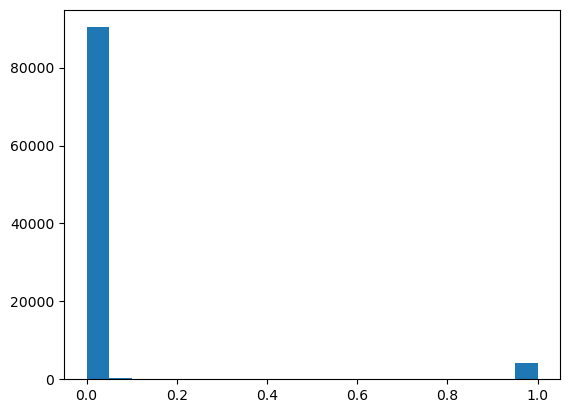

In [36]:
plt.hist(y_pred_prob, bins=20)

In [39]:
np.sort(y_pred_prob)

array([8.76852176e-09, 8.76852176e-09, 8.76852176e-09, ...,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00])

In [43]:
(y_pred_prob>0.8).sum()

4527

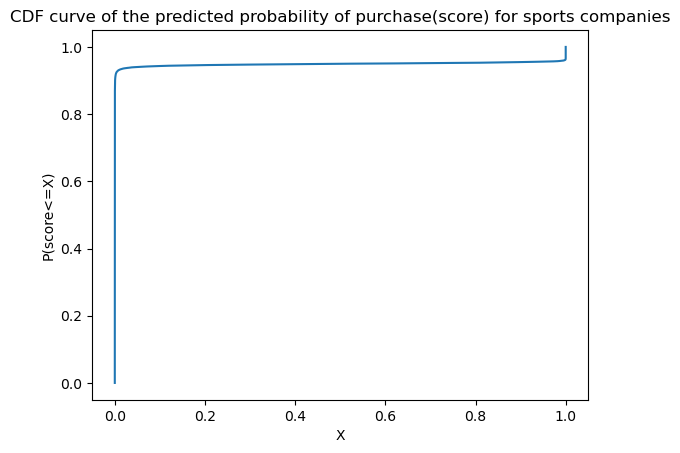

In [54]:
# number of observations
N = len(y_pred_prob)

# sort the data in ascending order 
y_pred_prob_sorted = np.sort(y_pred_prob) 

# get the cdf values of y 
steps = np.arange(N) / N
  
# plotting 
plt.xlabel('X') 
plt.ylabel('P(score<=X)') 
  
plt.title('CDF curve of the predicted probability of purchasec(score) for sports companies') 
  
plt.plot(y_pred_prob_sorted, steps) 
plt.show()

In [60]:
# on regarde de plus près les quantiles (on identifie 2 clusters, où est le cut-off ?)

np.linspace(0,1, 21)

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [59]:
y_pred_prob_sorted[y_pred_prob < 0.1].shape

(90634,)

In [65]:
for step in np.linspace(0,1, 21) :
    score_reached = y_pred_prob_sorted[int(step*N)-1]
    print(f"score du quantile {step} : {score_reached}")



score du quantile 0.0 : 1.0
score du quantile 0.05 : 1.1703610048497538e-08
score du quantile 0.1 : 1.1916538583855572e-08
score du quantile 0.15000000000000002 : 1.672960453020865e-08
score du quantile 0.2 : 2.261530896018714e-08
score du quantile 0.25 : 4.429426100901144e-08
score du quantile 0.30000000000000004 : 5.527720441770875e-08
score du quantile 0.35000000000000003 : 6.583003552085313e-08
score du quantile 0.4 : 1.0150014636815537e-07
score du quantile 0.45 : 1.045553983975125e-07
score du quantile 0.5 : 1.8254643649033717e-07
score du quantile 0.55 : 1.0036337913333724e-06
score du quantile 0.6000000000000001 : 3.6006418270834777e-06
score du quantile 0.65 : 8.750051427856617e-06
score du quantile 0.7000000000000001 : 1.7761176996762073e-05
score du quantile 0.75 : 3.658511676930477e-05
score du quantile 0.8 : 7.449089979671675e-05
score du quantile 0.8500000000000001 : 0.0001599334998042523
score du quantile 0.9 : 0.0006156933309033692
score du quantile 0.9500000000000001 :

In [67]:
# le saut survient entre le quantile 0.94 et 0.955
# on peut prendre le quantile 0.95 / score = 0.52 comme cut-off approximatif
for step in np.linspace(0.94,0.96, 21) :
    score_reached = y_pred_prob_sorted[int(step*N)-1]
    print(f"score du quantile {step} : {score_reached}")

score du quantile 0.94 : 0.046364832132301186
score du quantile 0.941 : 0.060426331367796585
score du quantile 0.942 : 0.07560789365683944
score du quantile 0.943 : 0.0961854989484283
score du quantile 0.944 : 0.12036366182214445
score du quantile 0.945 : 0.15326229828189683
score du quantile 0.946 : 0.20141929276940546
score du quantile 0.947 : 0.26129057078459816
score du quantile 0.948 : 0.34459110917836233
score du quantile 0.949 : 0.42441766527261676
score du quantile 0.95 : 0.5161846499348189
score du quantile 0.951 : 0.6281715747542238
score du quantile 0.952 : 0.7161294443763133
score du quantile 0.953 : 0.8098274658632696
score du quantile 0.954 : 0.8628210594682936
score du quantile 0.955 : 0.9031546758694196
score du quantile 0.956 : 0.9406325197642711
score du quantile 0.957 : 0.9717094630837765
score du quantile 0.958 : 0.9853416074407844
score du quantile 0.959 : 0.99263528504162
score du quantile 0.96 : 0.9965103675841931


In [90]:
# simple K-means pour déterminer le seuil qui sépare les 2 clusters apparents

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0)

kmeans.fit(y_pred_prob.reshape(-1,1))

KMeans(n_clusters=2, random_state=0)

In [91]:
y_clusters = kmeans.predict(y_pred_prob.reshape(-1,1))
y_clusters

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [93]:
y_clusters[y_clusters==1].size

4846

In [94]:
# 5% des individus sont dans le cluster 1
1 - y_clusters.mean()

0.9495712620712621

Intérêt du K-means : permet d'identifier un seuil de passage d'un cluster à l'autre quand le cluster est restreint, comme ici où on isole les clients avec la proba d'achat dans le quantile 0.95, et on les sépare des 95% restant

In [95]:
# seuil de split 

size_cluster_0 = 1 - y_clusters.mean()
seuil_cluster = y_pred_prob_sorted[int(1 - y_clusters.mean()*N)]

print(f"part d'individus dans le cluster 0 : {size_cluster_0}")
print(f"seuil de passage du cluster 0 au cluster 1 : {seuil_cluster}")

part d'individus dans le cluster 0 : 0.9495712620712621
seuil de passage du cluster 0 au cluster 1 : 0.4855790414879801
